# In this method, I uniformly sample the x,y position of the wrist data. And use those as features. 


Scenario4: Beans

Bad moved to Right, Good moved to Left [Manually encoding the relationship]

## NOTE
    Change <ksize> and <levels> according to how much history (also called features for TCN) being taken into account

In [1]:
import numpy as np
import time
import os
import matplotlib.pyplot as plt


In [2]:
from common_utils.feature_extraction import ExtractFeatures
from common_utils.Dataset import Dataset, PredictionDataset
from common_utils.classifier import InferenceModel


In [3]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report


import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
from torch import nn
# from torch.nn import SmoothL1Loss

from common_utils.tcn_model import TCN
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render, init_notebook_plotting

from functools import partial

from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [4]:
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render, init_notebook_plotting


In [5]:
from functools import partial

from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [6]:
# data_path = "/home/ur5/remote_dir/KB Autonomous Robotics/2021/LabGradingSortingDataset/Side-view-KB00-05-03-2021/scenario-4/beans"
data_path = "/home/ur5/sandbox/har_scenario_modeling/data/har_scenario_key_points_csvs_data/scenario-4/beans"

#HAR scenario config file with joint of interest
har_cfg_f = "/home/ur5/sandbox/har_scenario_modeling/common_utils/har_scenario_config.json"

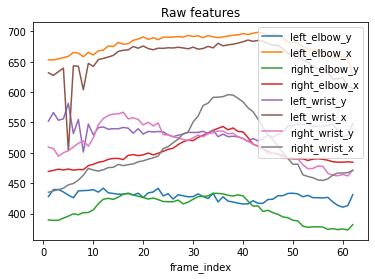

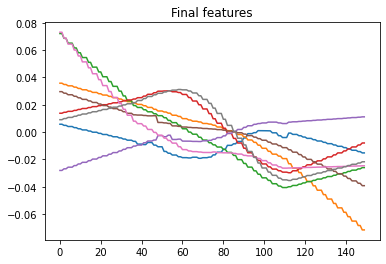

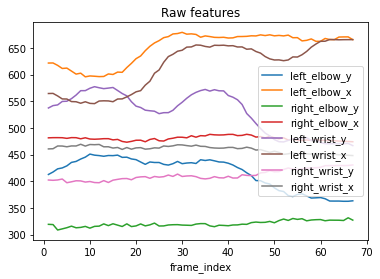

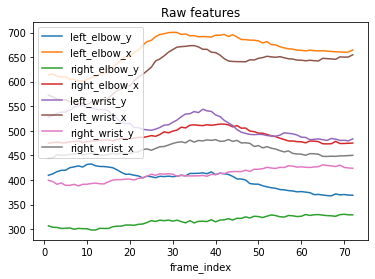

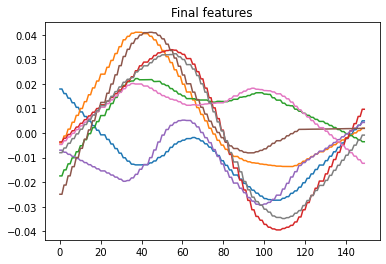

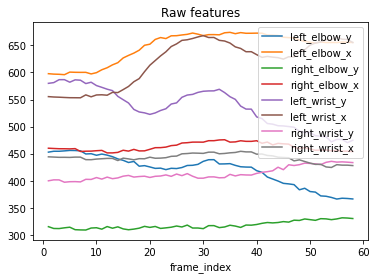

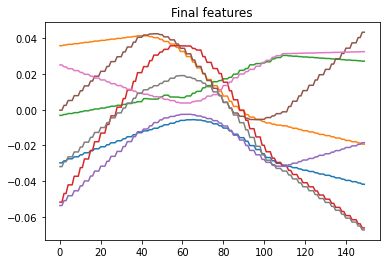

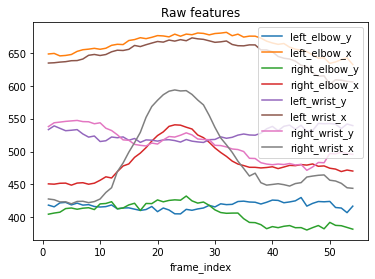

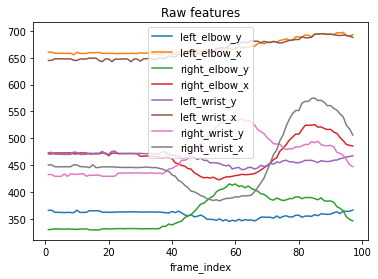

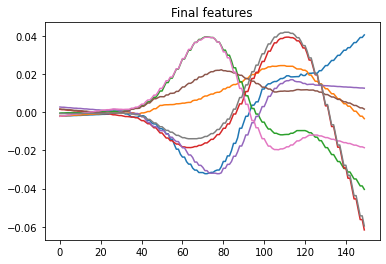

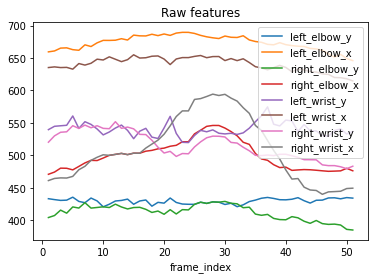

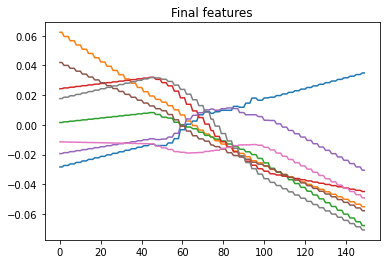

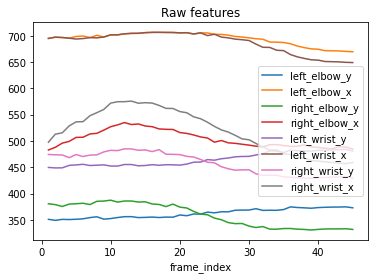

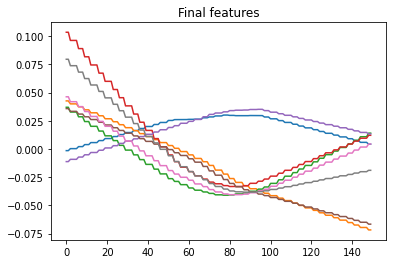

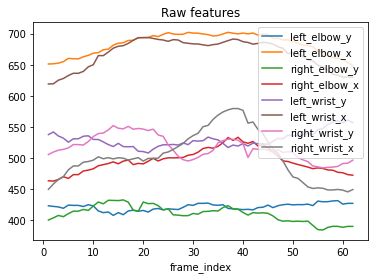

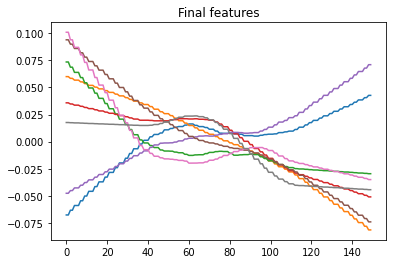

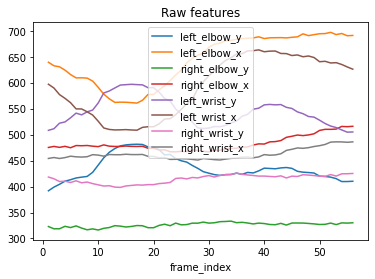

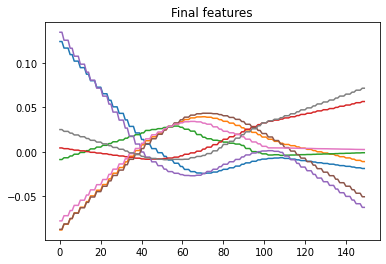

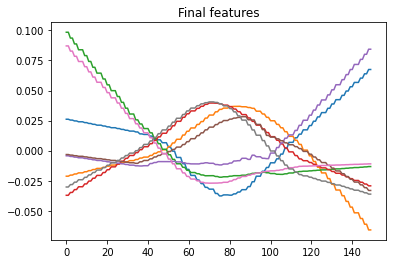

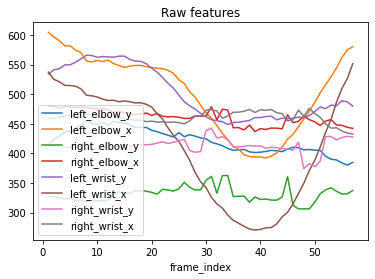

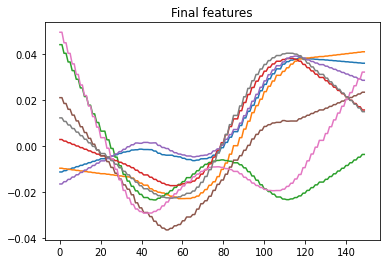

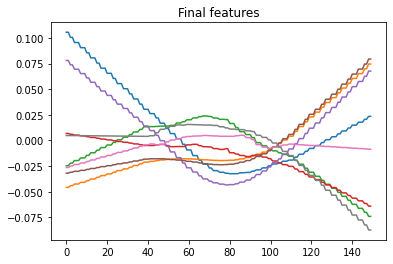

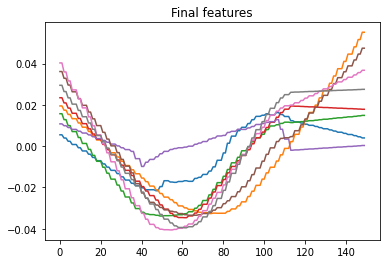

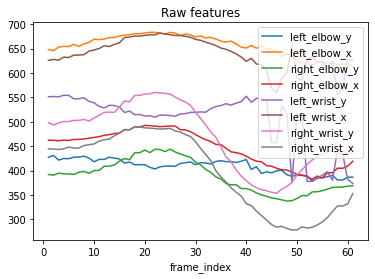

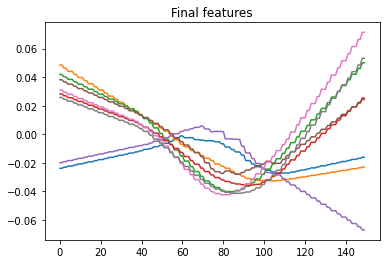

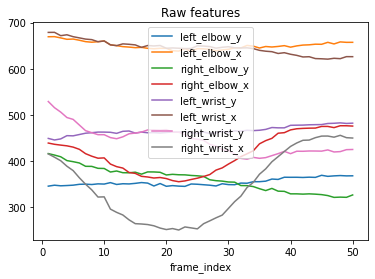

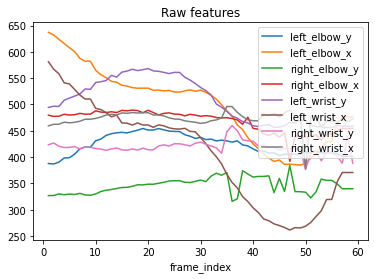

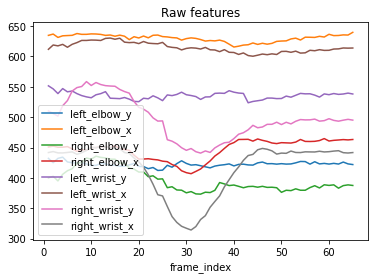

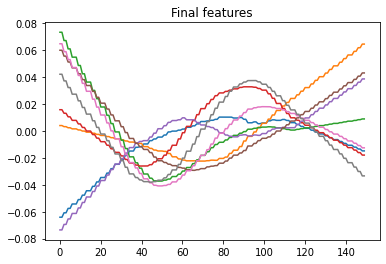

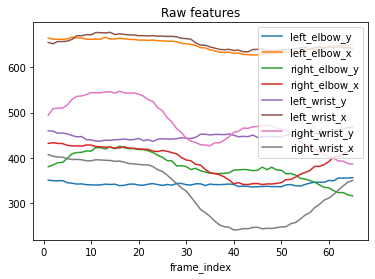

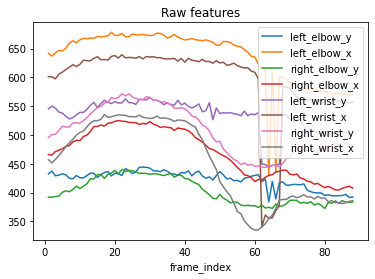

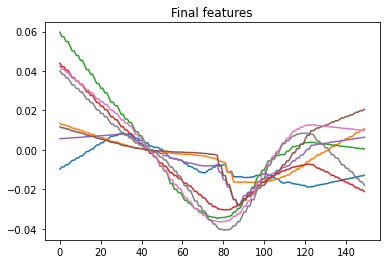

In [7]:
fe = ExtractFeatures(data_path, har_cfg_f)
X, Labels = fe.generate_features(draw_plots=True)


In [8]:
print(X.shape, np.unique(Labels))
print(np.unique(Labels).size)

(26, 150, 8) ['bad' 'good']
2


In [9]:
for ix, l in enumerate(Labels):
    if l == ['good']:
        Labels[ix] = ['good_left']
    else:
        Labels[ix] = ['bad_right']

In [10]:
print(X.shape, np.unique(Labels))

(26, 150, 8) ['bad_right' 'good_left']


In [11]:
# Labels
#Convert Labels to numerical labels
def label_encoder( text_labels):
    le = preprocessing.LabelEncoder()
    le.fit(np.unique(text_labels))
    return le

LE = label_encoder(Labels)
#Convert Labels to numerical labels
Y = LE.transform(Labels.ravel())

In [12]:
# Train-val, test split
#Create train, test and val sets
# Train-val, test split
#Create train, test and val sets
# X_train_all, X_test, y_train_all, y_test = train_test_split(X, Y, test_size=0.1, stratify=Y, random_state=1111)
# X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.15, stratify=y_train_all, random_state=1111)
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.15, stratify=Y, random_state=1111)

In [13]:
print(X_train.shape, X_val.shape)#, X_test.shape)#, X_train.dtype)

(22, 150, 8) (4, 150, 8)


In [14]:
print(X.shape)
# print(y_test)
print(y_val)

(26, 150, 8)
[1 1 0 0]


# 1.1 Convert dataset to Pytorch format
## Note that I am using trianing and test set, no validation set
## Also, no cross validation done [For later]

In [15]:

class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, data, labels):
        self.labels = labels
        self.data = data    
   
    def __len__(self):
        'total number of samples'
        return len(self.data)

    def __getitem__(self, idx):
        'get sample at index <idx>'
        # Select sample
        _X = self.data[idx, :].astype(np.float64)
        #print(_X.dtype)
        _y = self.labels[idx].astype(np.float64)

        
        return _X, _y


In [16]:
# for data, target in test_generator:
#     print(target)
#     break

# for data, target in training_generator:
#     print(data.shape, target.shape)
#     break

# 2. TCN Training and Testing

In [17]:
 
# Basically the receptive field is 
# kernel_size*last_value_of_dilation (assuming all powers of two).
# Also, if you want to cover the whole sequence you can consider 
# these parameters (for feature size 50):

# dilations = [1, 2, 4, 8, 16, 32], kernel = 2
# dilations = [1, 2, 4, 8, 16, 32], kernel = 3
# dilations = [1, 2, 4, 8, 16], kernel = 5
# dilations = [1, 2, 4, 8], kernel = 7 #This should go to 32, but only 5 wavelengths are missing
# dilations = [1, 2, 4, 8], kernel = 9
# dilations = [1, 2, 4, 8], kernel = 11
# dilations = [1, 2, 4], kernel = 13
# dilations = [1, 2, 4], kernel = 15
# dilations = [1], kernel = 50


# That is, ksize=3, then levels = 6, for a feature vector of size 50
# That is, ksize=7, then levels = 4, for a feature vector of size 50
# That is, ksize=13, then levels = 3, for a feature vector of size 50



In [18]:
#Best for now: 
#

#Variables

output_size = 1 #In binary case, this is 1, in multi-label case, this would be more

# batch_size = 1 # 

dropout = 0.1 #
clip = -1
# epochs = 2000 #
log_interval = 10
seed = 1111

input_channels = X_train.shape[2] #feature size (or  number of joint positions)
seq_length = X_train.shape[1] #This is the size of the temporal dimension
steps = 0
# train_loader = train
cuda=False
if torch.cuda.is_available():
    cuda = True

permute = False

# lr = 5e-5 
# wdecay = 1e-8

ksize = 7 #13 #7 #
levels = 4 #3 #4 #
# num_channels_each_tcn_layer = 10 #OK....this is the number of channels per layer, not hidden units
# channel_sizes = [num_channels_each_tcn_layer] * levels #Defines the nubers of hidden layers



In [19]:
# model = TCN(input_channels, n_classes, channel_sizes, ksize, config["dropout"]).double()

# if cuda: 
#     model.to(torch.device('cuda'))
# else:
#     model.to(torch.device('cpu'))

# optimizer = optim.Adam(model.parameters(), config["weight_decay"], config["lr"])


In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [21]:
#Assumes X_train and X_val are globally defined. Need to improve that
def train_tcn_hyp_param_tune(config, checkpoint_dir=None, data_dir=None):#, input_channels, n_classes, channle_sizes, dropoout):
    #model = TCN(input_channels, n_classes, channel_sizes, ksize, config["dropout"]).double()
    num_channels_each_tcn_layer = config['num_channels_each_tcn_layer']
    channel_sizes = [num_channels_each_tcn_layer] * levels #Defines the nubers of hidden layers

    model = TCN(input_channels, output_size, channel_sizes, ksize, dropout).double()
    device = 'cpu'
    cuda=False
    if torch.cuda.is_available(): 
        device = 'cuda'
        cuda=True

    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
#     optimizer = optim.Adam(model.parameters(), weight_decay=config["weight_decay"], lr=config["lr"])
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])

    

#     if checkpoint_dir: Don't have yet
#         model_state, optimizer_state = torch.load(
#             os.path.join(checkpoint_dir, "checkpoint"))
#         net.load_state_dict(model_state)
#         optimizer.load_state_dict(optimizer_state)
    training_set = Dataset(data=X_train, labels=y_train)
    training_generator = DataLoader(training_set, batch_size=3, shuffle=True, num_workers=1)


    val_set = Dataset(data=X_val, labels=y_val)
    val_generator = DataLoader(val_set, batch_size=3, shuffle=True, num_workers=1)

    for epoch in range(config['max_num_epochs']):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        
        train_loss = 0
        model.train()

        # Training
        for batch_idx, (data, target) in enumerate(training_generator):
            if cuda: 
                data, target = data.cuda(), target.cuda()
            target = target.unsqueeze(1)

            data = data.view(-1, input_channels, seq_length)
            data, target = Variable(data), Variable(target)

            optimizer.zero_grad()
            pred = model(data)
            
            loss_fn = nn.BCEWithLogitsLoss()
            loss = loss_fn(pred.double(), target.double())

            loss.backward()
    
            optimizer.step()
            running_loss += loss.item()
            epoch_steps += 1


            if batch_idx > 0 and batch_idx % log_interval == 0:
                print("[%d, %5d] loss: %.3f" % (epoch + 1, batch_idx + 1,
                                                running_loss / epoch_steps))

                running_loss = 0.0
            


        # Validation loss
        model.eval()
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        
        with torch.no_grad():
            for data, target in val_generator:
                if cuda:
                    data, target = data.cuda(), target.cuda()

                target = target.unsqueeze(1)

                data = data.view(-1, input_channels, seq_length)
                data, target = Variable(data), Variable(target)
                output = model(data.double())

                loss_fn = nn.BCEWithLogitsLoss()
                loss = loss_fn(output.double(), target.double()).item()
#                 val_loss += loss.cpu().numpy()
                val_loss += loss

                pred = torch.round(torch.sigmoid(output)).data
#                 pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).cpu().sum()
                total += target.size(0)

                
                val_steps += 1
        
        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((model.state_dict(), optimizer.state_dict()), path)
        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)

                
    print("Finished Training")

In [22]:
def main_run(num_samples=10, max_num_epochs=100, gpus_per_trial=1):
    data_dir = None
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    config = {
#     "weight_decay": tune.loguniform(1e-8, 1e-6),
#     "lr": tune.loguniform(1e-6, 1e-5),
    "max_num_epochs": tune.choice([100, 200, 300, 400]),
    "lr": tune.choice([1e-5, 1e-4, 1e-3]),
    "num_channels_each_tcn_layer": tune.choice([15, 20, 25]) 
#     "batch_size": tune.choice([2, 4, 8, 16])
    }
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period= int(max_num_epochs/4),
        reduction_factor=4)
    reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "accuracy", "training_iteration"])
    result = tune.run(
        partial(train_tcn_hyp_param_tune, data_dir=data_dir),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

    return best_trial

    


In [23]:
#     test_acc = test_accuracy(best_trained_model, device) 
#     print("Best trial test set accuracy: {}".format(test_acc))


# if __name__ == "__main__":
#     # You can change the number of GPUs per trial here:
gpus_per_trial = 1
best_trial = main_run(num_samples=20, max_num_epochs=500, gpus_per_trial=1)
#main_run(num_samples=1, max_num_epochs=5, gpus_per_trial=1)
#Get the best model
best_num_channels_each_tcn_layer = best_trial.config['num_channels_each_tcn_layer']
best_channel_sizes = [best_num_channels_each_tcn_layer] * levels #Defines the nubers of hidden layers

best_trained_model = TCN(input_channels, output_size, best_channel_sizes, ksize, dropout).double()



device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
    if gpus_per_trial > 1:
        best_trained_model = nn.DataParallel(best_trained_model)
best_trained_model.to(device)

best_checkpoint_dir = best_trial.checkpoint.value
print(best_checkpoint_dir)
model_state, optimizer_state = torch.load(os.path.join(
    best_checkpoint_dir, "checkpoint"))
best_trained_model.load_state_dict(model_state)


2022-08-19 14:14:18,658	WARNING experiment.py:255 -- No name detected on trainable. Using DEFAULT.
2022-08-19 14:14:18,659	INFO registry.py:69 -- Detected unknown callable for trainable. Converting to class.


== Status ==
Current time: 2022-08-19 14:14:18 (running for 00:00:00.26)
Memory usage on this node: 15.2/31.2 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 500.000: None | Iter 125.000: None
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (19 PENDING, 1 RUNNING)
+---------------------+----------+-------------------+--------+------------------+-------------------------------+
| Trial name          | status   | loc               |     lr |   max_num_epochs |   num_channels_each_tcn_layer |
|---------------------+----------+-------------------+--------+------------------+-------------------------------|
| DEFAULT_73480_00000 | RUNNING  | 10.72.1.53:911111 | 0.001  |              300 |                            25 |
| DEFAULT_73480_00001 | PENDING  |                   | 1e-05  |              300 |                            20

== Status ==
Current time: 2022-08-19 14:14:29 (running for 00:00:10.40)
Memory usage on this node: 20.7/31.2 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 500.000: None | Iter 125.000: None
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (19 PENDING, 1 RUNNING)
+---------------------+----------+-------------------+--------+------------------+-------------------------------+------------+------------+----------------------+
| Trial name          | status   | loc               |     lr |   max_num_epochs |   num_channels_each_tcn_layer |       loss |   accuracy |   training_iteration |
|---------------------+----------+-------------------+--------+------------------+-------------------------------+------------+------------+----------------------|
| DEFAULT_73480_00000 | RUNNING  | 10.72.1.53:911111 | 0.001  |              300

Result for DEFAULT_73480_00000:
  accuracy: tensor(1.)
  date: 2022-08-19_14-14-37
  done: false
  experiment_id: b98f9f8d711d4000836920dc732edbae
  hostname: ur5-desktop
  iterations_since_restore: 45
  loss: 4.3877203811879834e-08
  node_ip: 10.72.1.53
  pid: 911111
  should_checkpoint: true
  time_since_restore: 17.925482273101807
  time_this_iter_s: 0.35495567321777344
  time_total_s: 17.925482273101807
  timestamp: 1660911277
  timesteps_since_restore: 0
  training_iteration: 45
  trial_id: '73480_00000'
  
== Status ==
Current time: 2022-08-19 14:14:39 (running for 00:00:20.88)
Memory usage on this node: 18.6/31.2 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 500.000: None | Iter 125.000: None
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (19 PENDING, 1 RUNNING)
+---------------------+----------+-------------------+

Result for DEFAULT_73480_00000:
  accuracy: tensor(1.)
  date: 2022-08-19_14-14-48
  done: false
  experiment_id: b98f9f8d711d4000836920dc732edbae
  hostname: ur5-desktop
  iterations_since_restore: 74
  loss: 1.6841410458293922e-09
  node_ip: 10.72.1.53
  pid: 911111
  should_checkpoint: true
  time_since_restore: 28.426396369934082
  time_this_iter_s: 0.42786502838134766
  time_total_s: 28.426396369934082
  timestamp: 1660911288
  timesteps_since_restore: 0
  training_iteration: 74
  trial_id: '73480_00000'
  
== Status ==
Current time: 2022-08-19 14:14:50 (running for 00:00:31.35)
Memory usage on this node: 20.8/31.2 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 500.000: None | Iter 125.000: None
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (19 PENDING, 1 RUNNING)
+---------------------+----------+-------------------+

Result for DEFAULT_73480_00000:
  accuracy: tensor(1.)
  date: 2022-08-19_14-14-58
  done: false
  experiment_id: b98f9f8d711d4000836920dc732edbae
  hostname: ur5-desktop
  iterations_since_restore: 103
  loss: 3.0209819824629735e-10
  node_ip: 10.72.1.53
  pid: 911111
  should_checkpoint: true
  time_since_restore: 39.03324770927429
  time_this_iter_s: 0.3375213146209717
  time_total_s: 39.03324770927429
  timestamp: 1660911298
  timesteps_since_restore: 0
  training_iteration: 103
  trial_id: '73480_00000'
  
== Status ==
Current time: 2022-08-19 14:15:00 (running for 00:00:41.92)
Memory usage on this node: 20.8/31.2 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 500.000: None | Iter 125.000: None
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (19 PENDING, 1 RUNNING)
+---------------------+----------+-------------------+-

Result for DEFAULT_73480_00000:
  accuracy: tensor(1.)
  date: 2022-08-19_14-15-09
  done: false
  experiment_id: b98f9f8d711d4000836920dc732edbae
  hostname: ur5-desktop
  iterations_since_restore: 133
  loss: 2.0545550443106193e-10
  node_ip: 10.72.1.53
  pid: 911111
  should_checkpoint: true
  time_since_restore: 49.34481239318848
  time_this_iter_s: 0.2604091167449951
  time_total_s: 49.34481239318848
  timestamp: 1660911309
  timesteps_since_restore: 0
  training_iteration: 133
  trial_id: '73480_00000'
  
== Status ==
Current time: 2022-08-19 14:15:10 (running for 00:00:52.12)
Memory usage on this node: 20.7/31.2 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 500.000: None | Iter 125.000: -2.5686978465778384e-10
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (19 PENDING, 1 RUNNING)
+---------------------+----------+--

Result for DEFAULT_73480_00000:
  accuracy: tensor(1.)
  date: 2022-08-19_14-15-19
  done: false
  experiment_id: b98f9f8d711d4000836920dc732edbae
  hostname: ur5-desktop
  iterations_since_restore: 164
  loss: 1.2858129374859365e-10
  node_ip: 10.72.1.53
  pid: 911111
  should_checkpoint: true
  time_since_restore: 59.837252140045166
  time_this_iter_s: 0.3943042755126953
  time_total_s: 59.837252140045166
  timestamp: 1660911319
  timesteps_since_restore: 0
  training_iteration: 164
  trial_id: '73480_00000'
  
== Status ==
Current time: 2022-08-19 14:15:21 (running for 00:01:02.37)
Memory usage on this node: 20.6/31.2 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 500.000: None | Iter 125.000: -2.5686978465778384e-10
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (19 PENDING, 1 RUNNING)
+---------------------+----------+

Result for DEFAULT_73480_00000:
  accuracy: tensor(1.)
  date: 2022-08-19_14-15-30
  done: false
  experiment_id: b98f9f8d711d4000836920dc732edbae
  hostname: ur5-desktop
  iterations_since_restore: 193
  loss: 1.1347460007803214e-10
  node_ip: 10.72.1.53
  pid: 911111
  should_checkpoint: true
  time_since_restore: 70.24876427650452
  time_this_iter_s: 0.3199942111968994
  time_total_s: 70.24876427650452
  timestamp: 1660911330
  timesteps_since_restore: 0
  training_iteration: 193
  trial_id: '73480_00000'
  
== Status ==
Current time: 2022-08-19 14:15:31 (running for 00:01:12.77)
Memory usage on this node: 20.6/31.2 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 500.000: None | Iter 125.000: -2.5686978465778384e-10
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (19 PENDING, 1 RUNNING)
+---------------------+----------+--

Result for DEFAULT_73480_00000:
  accuracy: tensor(1.)
  date: 2022-08-19_14-15-40
  done: false
  experiment_id: b98f9f8d711d4000836920dc732edbae
  hostname: ur5-desktop
  iterations_since_restore: 223
  loss: 6.765262423979887e-11
  node_ip: 10.72.1.53
  pid: 911111
  should_checkpoint: true
  time_since_restore: 80.6387403011322
  time_this_iter_s: 0.36071038246154785
  time_total_s: 80.6387403011322
  timestamp: 1660911340
  timesteps_since_restore: 0
  training_iteration: 223
  trial_id: '73480_00000'
  
== Status ==
Current time: 2022-08-19 14:15:41 (running for 00:01:23.05)
Memory usage on this node: 20.6/31.2 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 500.000: None | Iter 125.000: -2.5686978465778384e-10
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (19 PENDING, 1 RUNNING)
+---------------------+----------+----

Result for DEFAULT_73480_00000:
  accuracy: tensor(1.)
  date: 2022-08-19_14-15-50
  done: false
  experiment_id: b98f9f8d711d4000836920dc732edbae
  hostname: ur5-desktop
  iterations_since_restore: 252
  loss: 3.516605525133852e-11
  node_ip: 10.72.1.53
  pid: 911111
  should_checkpoint: true
  time_since_restore: 90.90568280220032
  time_this_iter_s: 0.31363439559936523
  time_total_s: 90.90568280220032
  timestamp: 1660911350
  timesteps_since_restore: 0
  training_iteration: 252
  trial_id: '73480_00000'
  
== Status ==
Current time: 2022-08-19 14:15:52 (running for 00:01:33.36)
Memory usage on this node: 20.4/31.2 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 500.000: None | Iter 125.000: -2.5686978465778384e-10
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (19 PENDING, 1 RUNNING)
+---------------------+----------+--

Result for DEFAULT_73480_00000:
  accuracy: tensor(1.)
  date: 2022-08-19_14-16-01
  done: false
  experiment_id: b98f9f8d711d4000836920dc732edbae
  hostname: ur5-desktop
  iterations_since_restore: 281
  loss: 2.732976807727137e-11
  node_ip: 10.72.1.53
  pid: 911111
  should_checkpoint: true
  time_since_restore: 101.24979066848755
  time_this_iter_s: 0.36268043518066406
  time_total_s: 101.24979066848755
  timestamp: 1660911361
  timesteps_since_restore: 0
  training_iteration: 281
  trial_id: '73480_00000'
  
== Status ==
Current time: 2022-08-19 14:16:02 (running for 00:01:43.86)
Memory usage on this node: 20.7/31.2 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 500.000: None | Iter 125.000: -2.5686978465778384e-10
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (19 PENDING, 1 RUNNING)
+---------------------+----------+

Result for DEFAULT_73480_00000:
  accuracy: tensor(1.)
  date: 2022-08-19_14-16-08
  done: true
  experiment_id: b98f9f8d711d4000836920dc732edbae
  experiment_tag: 0_lr=0.001,max_num_epochs=300,num_channels_each_tcn_layer=25
  hostname: ur5-desktop
  iterations_since_restore: 300
  loss: 4.723040477045824e-11
  node_ip: 10.72.1.53
  pid: 911111
  should_checkpoint: true
  time_since_restore: 108.29166388511658
  time_this_iter_s: 0.3632645606994629
  time_total_s: 108.29166388511658
  timestamp: 1660911368
  timesteps_since_restore: 0
  training_iteration: 300
  trial_id: '73480_00000'
  
(ImplicitFunc pid=911111) Finished Training
Result for DEFAULT_73480_00001:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-16-11
  done: false
  experiment_id: 510e3cd043f241a09f755319e69a8a7e
  hostname: ur5-desktop
  iterations_since_restore: 1
  loss: 0.6512389622773945
  node_ip: 10.72.1.53
  pid: 911117
  should_checkpoint: true
  time_since_restore: 2.426379680633545
  time_this_iter_s: 2.4263

Result for DEFAULT_73480_00001:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-16-21
  done: false
  experiment_id: 510e3cd043f241a09f755319e69a8a7e
  hostname: ur5-desktop
  iterations_since_restore: 30
  loss: 0.651611681068119
  node_ip: 10.72.1.53
  pid: 911117
  should_checkpoint: true
  time_since_restore: 12.767422676086426
  time_this_iter_s: 0.3283824920654297
  time_total_s: 12.767422676086426
  timestamp: 1660911381
  timesteps_since_restore: 0
  training_iteration: 30
  trial_id: '73480_00001'
  
== Status ==
Current time: 2022-08-19 14:16:23 (running for 00:02:04.70)
Memory usage on this node: 20.4/31.2 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 500.000: None | Iter 125.000: -2.5686978465778384e-10
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (18 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+

Result for DEFAULT_73480_00001:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-16-32
  done: false
  experiment_id: 510e3cd043f241a09f755319e69a8a7e
  hostname: ur5-desktop
  iterations_since_restore: 60
  loss: 0.6530068346166744
  node_ip: 10.72.1.53
  pid: 911117
  should_checkpoint: true
  time_since_restore: 23.267194032669067
  time_this_iter_s: 0.38837647438049316
  time_total_s: 23.267194032669067
  timestamp: 1660911392
  timesteps_since_restore: 0
  training_iteration: 60
  trial_id: '73480_00001'
  
== Status ==
Current time: 2022-08-19 14:16:33 (running for 00:02:14.95)
Memory usage on this node: 20.5/31.2 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 500.000: None | Iter 125.000: -2.5686978465778384e-10
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (18 PENDING, 1 RUNNING, 1 TERMINATED)
+--------------------

Result for DEFAULT_73480_00001:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-16-42
  done: false
  experiment_id: 510e3cd043f241a09f755319e69a8a7e
  hostname: ur5-desktop
  iterations_since_restore: 88
  loss: 0.6531573044531795
  node_ip: 10.72.1.53
  pid: 911117
  should_checkpoint: true
  time_since_restore: 33.51253366470337
  time_this_iter_s: 0.3954486846923828
  time_total_s: 33.51253366470337
  timestamp: 1660911402
  timesteps_since_restore: 0
  training_iteration: 88
  trial_id: '73480_00001'
  
== Status ==
Current time: 2022-08-19 14:16:43 (running for 00:02:25.22)
Memory usage on this node: 20.5/31.2 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 500.000: None | Iter 125.000: -2.5686978465778384e-10
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (18 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+-

Result for DEFAULT_73480_00001:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-16-52
  done: false
  experiment_id: 510e3cd043f241a09f755319e69a8a7e
  hostname: ur5-desktop
  iterations_since_restore: 116
  loss: 0.7539027133797012
  node_ip: 10.72.1.53
  pid: 911117
  should_checkpoint: true
  time_since_restore: 43.669201135635376
  time_this_iter_s: 0.4269886016845703
  time_total_s: 43.669201135635376
  timestamp: 1660911412
  timesteps_since_restore: 0
  training_iteration: 116
  trial_id: '73480_00001'
  
== Status ==
Current time: 2022-08-19 14:16:54 (running for 00:02:35.68)
Memory usage on this node: 20.5/31.2 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 500.000: None | Iter 125.000: -2.5686978465778384e-10
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (18 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------

Result for DEFAULT_73480_00002:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-17-04
  done: false
  experiment_id: a0c1597532e242a9baee883ddae5f6ae
  hostname: ur5-desktop
  iterations_since_restore: 15
  loss: 0.6683684803672763
  node_ip: 10.72.1.53
  pid: 911110
  should_checkpoint: true
  time_since_restore: 7.523318290710449
  time_this_iter_s: 0.35005736351013184
  time_total_s: 7.523318290710449
  timestamp: 1660911424
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: '73480_00002'
  
== Status ==
Current time: 2022-08-19 14:17:04 (running for 00:02:45.94)
Memory usage on this node: 19.5/31.2 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 500.000: None | Iter 125.000: -0.1882053840954686
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (17 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+----

Result for DEFAULT_73480_00002:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-17-14
  done: false
  experiment_id: a0c1597532e242a9baee883ddae5f6ae
  hostname: ur5-desktop
  iterations_since_restore: 43
  loss: 0.7222931322861325
  node_ip: 10.72.1.53
  pid: 911110
  should_checkpoint: true
  time_since_restore: 17.758658170700073
  time_this_iter_s: 0.39949893951416016
  time_total_s: 17.758658170700073
  timestamp: 1660911434
  timesteps_since_restore: 0
  training_iteration: 43
  trial_id: '73480_00002'
  
== Status ==
Current time: 2022-08-19 14:17:14 (running for 00:02:56.12)
Memory usage on this node: 20.4/31.2 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 500.000: None | Iter 125.000: -0.1882053840954686
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (17 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+--

Result for DEFAULT_73480_00002:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-17-24
  done: false
  experiment_id: a0c1597532e242a9baee883ddae5f6ae
  hostname: ur5-desktop
  iterations_since_restore: 71
  loss: 0.7196590245065262
  node_ip: 10.72.1.53
  pid: 911110
  should_checkpoint: true
  time_since_restore: 28.019289016723633
  time_this_iter_s: 0.3201005458831787
  time_total_s: 28.019289016723633
  timestamp: 1660911444
  timesteps_since_restore: 0
  training_iteration: 71
  trial_id: '73480_00002'
  
== Status ==
Current time: 2022-08-19 14:17:25 (running for 00:03:06.50)
Memory usage on this node: 20.4/31.2 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 500.000: None | Iter 125.000: -0.1882053840954686
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (17 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+---

Result for DEFAULT_73480_00002:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-17-35
  done: false
  experiment_id: a0c1597532e242a9baee883ddae5f6ae
  hostname: ur5-desktop
  iterations_since_restore: 99
  loss: 0.7171981567276214
  node_ip: 10.72.1.53
  pid: 911110
  should_checkpoint: true
  time_since_restore: 38.280295848846436
  time_this_iter_s: 0.3351137638092041
  time_total_s: 38.280295848846436
  timestamp: 1660911455
  timesteps_since_restore: 0
  training_iteration: 99
  trial_id: '73480_00002'
  
== Status ==
Current time: 2022-08-19 14:17:35 (running for 00:03:16.66)
Memory usage on this node: 18.3/31.2 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 500.000: None | Iter 125.000: -0.1882053840954686
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (17 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+---

Result for DEFAULT_73480_00002:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-17-43
  done: true
  experiment_id: a0c1597532e242a9baee883ddae5f6ae
  hostname: ur5-desktop
  iterations_since_restore: 125
  loss: 0.674540724388742
  node_ip: 10.72.1.53
  pid: 911110
  should_checkpoint: true
  time_since_restore: 47.188852310180664
  time_this_iter_s: 0.36304235458374023
  time_total_s: 47.188852310180664
  timestamp: 1660911463
  timesteps_since_restore: 0
  training_iteration: 125
  trial_id: '73480_00002'
  
== Status ==
Current time: 2022-08-19 14:17:46 (running for 00:03:27.29)
Memory usage on this node: 19.5/31.2 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 500.000: None | Iter 125.000: -0.33727036232280594
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (16 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+-

Result for DEFAULT_73480_00003:
  accuracy: tensor(1.)
  date: 2022-08-19_14-17-52
  done: false
  experiment_id: 5dcd1ce2f4f54ce58377c53fc2c9b5d5
  hostname: ur5-desktop
  iterations_since_restore: 16
  loss: 0.1359475027406078
  node_ip: 10.72.1.53
  pid: 911128
  should_checkpoint: true
  time_since_restore: 7.790924072265625
  time_this_iter_s: 0.3778679370880127
  time_total_s: 7.790924072265625
  timestamp: 1660911472
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: '73480_00003'
  
== Status ==
Current time: 2022-08-19 14:17:56 (running for 00:03:37.67)
Memory usage on this node: 20.3/31.2 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 500.000: None | Iter 125.000: -0.33727036232280594
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (16 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+--------

Result for DEFAULT_73480_00003:
  accuracy: tensor(1.)
  date: 2022-08-19_14-18-03
  done: false
  experiment_id: 5dcd1ce2f4f54ce58377c53fc2c9b5d5
  hostname: ur5-desktop
  iterations_since_restore: 44
  loss: 2.566824630392733e-06
  node_ip: 10.72.1.53
  pid: 911128
  should_checkpoint: true
  time_since_restore: 18.241353034973145
  time_this_iter_s: 0.35495424270629883
  time_total_s: 18.241353034973145
  timestamp: 1660911483
  timesteps_since_restore: 0
  training_iteration: 44
  trial_id: '73480_00003'
  
== Status ==
Current time: 2022-08-19 14:18:06 (running for 00:03:48.21)
Memory usage on this node: 20.2/31.2 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 500.000: None | Iter 125.000: -0.33727036232280594
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (16 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+--

Result for DEFAULT_73480_00003:
  accuracy: tensor(1.)
  date: 2022-08-19_14-18-13
  done: false
  experiment_id: 5dcd1ce2f4f54ce58377c53fc2c9b5d5
  hostname: ur5-desktop
  iterations_since_restore: 71
  loss: 1.01741099294019e-06
  node_ip: 10.72.1.53
  pid: 911128
  should_checkpoint: true
  time_since_restore: 28.550954580307007
  time_this_iter_s: 0.3746938705444336
  time_total_s: 28.550954580307007
  timestamp: 1660911493
  timesteps_since_restore: 0
  training_iteration: 71
  trial_id: '73480_00003'
  
== Status ==
Current time: 2022-08-19 14:18:17 (running for 00:03:58.79)
Memory usage on this node: 20.3/31.2 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 500.000: None | Iter 125.000: -0.33727036232280594
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (16 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+----

Result for DEFAULT_73480_00003:
  accuracy: tensor(1.)
  date: 2022-08-19_14-18-23
  done: false
  experiment_id: 5dcd1ce2f4f54ce58377c53fc2c9b5d5
  hostname: ur5-desktop
  iterations_since_restore: 99
  loss: 7.196034604529995e-07
  node_ip: 10.72.1.53
  pid: 911128
  should_checkpoint: true
  time_since_restore: 38.93127799034119
  time_this_iter_s: 0.35391783714294434
  time_total_s: 38.93127799034119
  timestamp: 1660911503
  timesteps_since_restore: 0
  training_iteration: 99
  trial_id: '73480_00003'
  
== Status ==
Current time: 2022-08-19 14:18:28 (running for 00:04:09.38)
Memory usage on this node: 20.1/31.2 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 500.000: None | Iter 125.000: -0.33727036232280594
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (16 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+----

Result for DEFAULT_73480_00003:
  accuracy: tensor(1.)
  date: 2022-08-19_14-18-33
  done: false
  experiment_id: 5dcd1ce2f4f54ce58377c53fc2c9b5d5
  hostname: ur5-desktop
  iterations_since_restore: 129
  loss: 1.6636438299332142e-07
  node_ip: 10.72.1.53
  pid: 911128
  should_checkpoint: true
  time_since_restore: 49.08323001861572
  time_this_iter_s: 0.3939383029937744
  time_total_s: 49.08323001861572
  timestamp: 1660911513
  timesteps_since_restore: 0
  training_iteration: 129
  trial_id: '73480_00003'
  
== Status ==
Current time: 2022-08-19 14:18:38 (running for 00:04:19.64)
Memory usage on this node: 20.0/31.2 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 500.000: None | Iter 125.000: -1.379267523250032e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (16 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+

Result for DEFAULT_73480_00003:
  accuracy: tensor(1.)
  date: 2022-08-19_14-18-44
  done: false
  experiment_id: 5dcd1ce2f4f54ce58377c53fc2c9b5d5
  hostname: ur5-desktop
  iterations_since_restore: 156
  loss: 7.099952589604852e-08
  node_ip: 10.72.1.53
  pid: 911128
  should_checkpoint: true
  time_since_restore: 59.25403547286987
  time_this_iter_s: 0.42206788063049316
  time_total_s: 59.25403547286987
  timestamp: 1660911524
  timesteps_since_restore: 0
  training_iteration: 156
  trial_id: '73480_00003'
  
== Status ==
Current time: 2022-08-19 14:18:48 (running for 00:04:30.25)
Memory usage on this node: 20.0/31.2 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 500.000: None | Iter 125.000: -1.379267523250032e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (16 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+

Result for DEFAULT_73480_00003:
  accuracy: tensor(1.)
  date: 2022-08-19_14-18-54
  done: false
  experiment_id: 5dcd1ce2f4f54ce58377c53fc2c9b5d5
  hostname: ur5-desktop
  iterations_since_restore: 184
  loss: 2.8622900501827037e-08
  node_ip: 10.72.1.53
  pid: 911128
  should_checkpoint: true
  time_since_restore: 69.60299849510193
  time_this_iter_s: 0.39542341232299805
  time_total_s: 69.60299849510193
  timestamp: 1660911534
  timesteps_since_restore: 0
  training_iteration: 184
  trial_id: '73480_00003'
  
== Status ==
Current time: 2022-08-19 14:18:59 (running for 00:04:40.67)
Memory usage on this node: 20.0/31.2 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 500.000: None | Iter 125.000: -1.379267523250032e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (16 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------

Result for DEFAULT_73480_00004:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-19-08
  done: false
  experiment_id: 62f1cd21f53e482fa5b55a153b5fa524
  hostname: ur5-desktop
  iterations_since_restore: 15
  loss: 0.7259967398786076
  node_ip: 10.72.1.53
  pid: 911121
  should_checkpoint: true
  time_since_restore: 7.32857346534729
  time_this_iter_s: 0.3661012649536133
  time_total_s: 7.32857346534729
  timestamp: 1660911548
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: '73480_00004'
  
== Status ==
Current time: 2022-08-19 14:19:09 (running for 00:04:50.76)
Memory usage on this node: 18.1/31.2 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 500.000: None | Iter 125.000: -1.379267523250032e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (15 PENDING, 1 RUNNING, 4 TERMINATED)
+---------------------+----

Result for DEFAULT_73480_00004:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-19-19
  done: false
  experiment_id: 62f1cd21f53e482fa5b55a153b5fa524
  hostname: ur5-desktop
  iterations_since_restore: 44
  loss: 0.6642088284981735
  node_ip: 10.72.1.53
  pid: 911121
  should_checkpoint: true
  time_since_restore: 17.801120042800903
  time_this_iter_s: 0.4173738956451416
  time_total_s: 17.801120042800903
  timestamp: 1660911559
  timesteps_since_restore: 0
  training_iteration: 44
  trial_id: '73480_00004'
  
== Status ==
Current time: 2022-08-19 14:19:19 (running for 00:05:01.27)
Memory usage on this node: 19.8/31.2 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 500.000: None | Iter 125.000: -1.379267523250032e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (15 PENDING, 1 RUNNING, 4 TERMINATED)
+---------------------+

Result for DEFAULT_73480_00004:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-19-29
  done: false
  experiment_id: 62f1cd21f53e482fa5b55a153b5fa524
  hostname: ur5-desktop
  iterations_since_restore: 72
  loss: 0.517630711863381
  node_ip: 10.72.1.53
  pid: 911121
  should_checkpoint: true
  time_since_restore: 28.28637671470642
  time_this_iter_s: 0.40677380561828613
  time_total_s: 28.28637671470642
  timestamp: 1660911569
  timesteps_since_restore: 0
  training_iteration: 72
  trial_id: '73480_00004'
  
== Status ==
Current time: 2022-08-19 14:19:30 (running for 00:05:11.39)
Memory usage on this node: 19.8/31.2 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 500.000: None | Iter 125.000: -1.379267523250032e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (15 PENDING, 1 RUNNING, 4 TERMINATED)
+---------------------+--

Result for DEFAULT_73480_00004:
  accuracy: tensor(1.)
  date: 2022-08-19_14-19-40
  done: false
  experiment_id: 62f1cd21f53e482fa5b55a153b5fa524
  hostname: ur5-desktop
  iterations_since_restore: 100
  loss: 0.008232772356467858
  node_ip: 10.72.1.53
  pid: 911121
  should_checkpoint: true
  time_since_restore: 38.79691982269287
  time_this_iter_s: 0.3386516571044922
  time_total_s: 38.79691982269287
  timestamp: 1660911580
  timesteps_since_restore: 0
  training_iteration: 100
  trial_id: '73480_00004'
  
Result for DEFAULT_73480_00004:
  accuracy: tensor(1.)
  date: 2022-08-19_14-19-40
  done: true
  experiment_id: 62f1cd21f53e482fa5b55a153b5fa524
  experiment_tag: 4_lr=0.0001,max_num_epochs=100,num_channels_each_tcn_layer=15
  hostname: ur5-desktop
  iterations_since_restore: 100
  loss: 0.008232772356467858
  node_ip: 10.72.1.53
  pid: 911121
  should_checkpoint: true
  time_since_restore: 38.79691982269287
  time_this_iter_s: 0.3386516571044922
  time_total_s: 38.79691982269287

Result for DEFAULT_73480_00005:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-19-48
  done: false
  experiment_id: 599fd189f112473ebf1dbb673d77e11b
  hostname: ur5-desktop
  iterations_since_restore: 15
  loss: 0.7166470744183275
  node_ip: 10.72.1.53
  pid: 911103
  should_checkpoint: true
  time_since_restore: 7.44503927230835
  time_this_iter_s: 0.35857653617858887
  time_total_s: 7.44503927230835
  timestamp: 1660911588
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: '73480_00005'
  
== Status ==
Current time: 2022-08-19 14:19:51 (running for 00:05:32.77)
Memory usage on this node: 19.7/31.2 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 500.000: None | Iter 125.000: -1.379267523250032e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (14 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+---

Result for DEFAULT_73480_00005:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-19-58
  done: false
  experiment_id: 599fd189f112473ebf1dbb673d77e11b
  hostname: ur5-desktop
  iterations_since_restore: 43
  loss: 0.7215413138895231
  node_ip: 10.72.1.53
  pid: 911103
  should_checkpoint: true
  time_since_restore: 17.82788348197937
  time_this_iter_s: 0.34102964401245117
  time_total_s: 17.82788348197937
  timestamp: 1660911598
  timesteps_since_restore: 0
  training_iteration: 43
  trial_id: '73480_00005'
  
== Status ==
Current time: 2022-08-19 14:20:01 (running for 00:05:42.93)
Memory usage on this node: 19.7/31.2 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 500.000: None | Iter 125.000: -1.379267523250032e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (14 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+-

Result for DEFAULT_73480_00005:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-20-09
  done: false
  experiment_id: 599fd189f112473ebf1dbb673d77e11b
  hostname: ur5-desktop
  iterations_since_restore: 70
  loss: 0.6333535351059469
  node_ip: 10.72.1.53
  pid: 911103
  should_checkpoint: true
  time_since_restore: 28.22033953666687
  time_this_iter_s: 0.370471715927124
  time_total_s: 28.22033953666687
  timestamp: 1660911609
  timesteps_since_restore: 0
  training_iteration: 70
  trial_id: '73480_00005'
  
== Status ==
Current time: 2022-08-19 14:20:12 (running for 00:05:53.39)
Memory usage on this node: 19.6/31.2 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 500.000: None | Iter 125.000: -1.379267523250032e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (14 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+---

Result for DEFAULT_73480_00005:
  accuracy: tensor(1.)
  date: 2022-08-19_14-20-19
  done: false
  experiment_id: 599fd189f112473ebf1dbb673d77e11b
  hostname: ur5-desktop
  iterations_since_restore: 96
  loss: 0.033135146609032884
  node_ip: 10.72.1.53
  pid: 911103
  should_checkpoint: true
  time_since_restore: 38.41727042198181
  time_this_iter_s: 0.35022521018981934
  time_total_s: 38.41727042198181
  timestamp: 1660911619
  timesteps_since_restore: 0
  training_iteration: 96
  trial_id: '73480_00005'
  
== Status ==
Current time: 2022-08-19 14:20:22 (running for 00:06:03.81)
Memory usage on this node: 19.6/31.2 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 500.000: None | Iter 125.000: -1.379267523250032e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (14 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+---

Result for DEFAULT_73480_00005:
  accuracy: tensor(1.)
  date: 2022-08-19_14-20-29
  done: false
  experiment_id: 599fd189f112473ebf1dbb673d77e11b
  hostname: ur5-desktop
  iterations_since_restore: 124
  loss: 0.00232235098440661
  node_ip: 10.72.1.53
  pid: 911103
  should_checkpoint: true
  time_since_restore: 48.78030204772949
  time_this_iter_s: 0.3788907527923584
  time_total_s: 48.78030204772949
  timestamp: 1660911629
  timesteps_since_restore: 0
  training_iteration: 124
  trial_id: '73480_00005'
  
Result for DEFAULT_73480_00005:
  accuracy: tensor(1.)
  date: 2022-08-19_14-20-30
  done: true
  experiment_id: 599fd189f112473ebf1dbb673d77e11b
  hostname: ur5-desktop
  iterations_since_restore: 125
  loss: 0.003313601597767683
  node_ip: 10.72.1.53
  pid: 911103
  should_checkpoint: true
  time_since_restore: 49.15907311439514
  time_this_iter_s: 0.3787710666656494
  time_total_s: 49.15907311439514
  timestamp: 1660911630
  timesteps_since_restore: 0
  training_iteration: 125
 

Result for DEFAULT_73480_00006:
  accuracy: tensor(1.)
  date: 2022-08-19_14-20-43
  done: false
  experiment_id: f814affce56e4daebd2aedfd4e315ad8
  hostname: ur5-desktop
  iterations_since_restore: 28
  loss: 0.00013106044141451741
  node_ip: 10.72.1.53
  pid: 911109
  should_checkpoint: true
  time_since_restore: 12.821452140808105
  time_this_iter_s: 0.39343738555908203
  time_total_s: 12.821452140808105
  timestamp: 1660911643
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: '73480_00006'
  
== Status ==
Current time: 2022-08-19 14:20:43 (running for 00:06:25.21)
Memory usage on this node: 19.5/31.2 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 500.000: None | Iter 125.000: -1.8381671317178498e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (13 PENDING, 1 RUNNING, 6 TERMINATED)
+--------------------

Result for DEFAULT_73480_00006:
  accuracy: tensor(1.)
  date: 2022-08-19_14-20-54
  done: false
  experiment_id: f814affce56e4daebd2aedfd4e315ad8
  hostname: ur5-desktop
  iterations_since_restore: 54
  loss: 7.268600074973383e-06
  node_ip: 10.72.1.53
  pid: 911109
  should_checkpoint: true
  time_since_restore: 22.998489379882812
  time_this_iter_s: 0.43955516815185547
  time_total_s: 22.998489379882812
  timestamp: 1660911654
  timesteps_since_restore: 0
  training_iteration: 54
  trial_id: '73480_00006'
  
== Status ==
Current time: 2022-08-19 14:20:54 (running for 00:06:35.40)
Memory usage on this node: 19.5/31.2 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 500.000: None | Iter 125.000: -1.8381671317178498e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (13 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------

Result for DEFAULT_73480_00006:
  accuracy: tensor(1.)
  date: 2022-08-19_14-21-04
  done: false
  experiment_id: f814affce56e4daebd2aedfd4e315ad8
  hostname: ur5-desktop
  iterations_since_restore: 82
  loss: 1.6314380728041553e-07
  node_ip: 10.72.1.53
  pid: 911109
  should_checkpoint: true
  time_since_restore: 33.67176938056946
  time_this_iter_s: 0.43990015983581543
  time_total_s: 33.67176938056946
  timestamp: 1660911664
  timesteps_since_restore: 0
  training_iteration: 82
  trial_id: '73480_00006'
  
== Status ==
Current time: 2022-08-19 14:21:04 (running for 00:06:46.08)
Memory usage on this node: 19.5/31.2 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 500.000: None | Iter 125.000: -1.8381671317178498e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (13 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+

Result for DEFAULT_73480_00006:
  accuracy: tensor(1.)
  date: 2022-08-19_14-21-10
  done: false
  experiment_id: f814affce56e4daebd2aedfd4e315ad8
  hostname: ur5-desktop
  iterations_since_restore: 96
  loss: 8.711718983507166e-08
  node_ip: 10.72.1.53
  pid: 911109
  should_checkpoint: true
  time_since_restore: 39.05592894554138
  time_this_iter_s: 0.380932092666626
  time_total_s: 39.05592894554138
  timestamp: 1660911670
  timesteps_since_restore: 0
  training_iteration: 96
  trial_id: '73480_00006'
  
== Status ==
Current time: 2022-08-19 14:21:14 (running for 00:06:56.20)
Memory usage on this node: 19.5/31.2 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 500.000: None | Iter 125.000: -1.8381671317178498e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (13 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+---

Result for DEFAULT_73480_00006:
  accuracy: tensor(1.)
  date: 2022-08-19_14-21-20
  done: false
  experiment_id: f814affce56e4daebd2aedfd4e315ad8
  hostname: ur5-desktop
  iterations_since_restore: 122
  loss: 1.4077890812892644e-07
  node_ip: 10.72.1.53
  pid: 911109
  should_checkpoint: true
  time_since_restore: 49.27306365966797
  time_this_iter_s: 0.39437031745910645
  time_total_s: 49.27306365966797
  timestamp: 1660911680
  timesteps_since_restore: 0
  training_iteration: 122
  trial_id: '73480_00006'
  
== Status ==
Current time: 2022-08-19 14:21:25 (running for 00:07:06.47)
Memory usage on this node: 19.5/31.2 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 500.000: None | Iter 125.000: -1.438903986464123e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (13 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------

Result for DEFAULT_73480_00006:
  accuracy: tensor(1.)
  date: 2022-08-19_14-21-30
  done: false
  experiment_id: f814affce56e4daebd2aedfd4e315ad8
  hostname: ur5-desktop
  iterations_since_restore: 148
  loss: 1.0612692886109118e-06
  node_ip: 10.72.1.53
  pid: 911109
  should_checkpoint: true
  time_since_restore: 59.63242816925049
  time_this_iter_s: 0.39797067642211914
  time_total_s: 59.63242816925049
  timestamp: 1660911690
  timesteps_since_restore: 0
  training_iteration: 148
  trial_id: '73480_00006'
  
== Status ==
Current time: 2022-08-19 14:21:35 (running for 00:07:16.92)
Memory usage on this node: 19.5/31.2 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 500.000: None | Iter 125.000: -1.438903986464123e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (13 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------

Result for DEFAULT_73480_00006:
  accuracy: tensor(1.)
  date: 2022-08-19_14-21-41
  done: false
  experiment_id: f814affce56e4daebd2aedfd4e315ad8
  hostname: ur5-desktop
  iterations_since_restore: 175
  loss: 3.928523907155636e-08
  node_ip: 10.72.1.53
  pid: 911109
  should_checkpoint: true
  time_since_restore: 70.04366707801819
  time_this_iter_s: 0.4417555332183838
  time_total_s: 70.04366707801819
  timestamp: 1660911701
  timesteps_since_restore: 0
  training_iteration: 175
  trial_id: '73480_00006'
  
== Status ==
Current time: 2022-08-19 14:21:46 (running for 00:07:27.45)
Memory usage on this node: 19.5/31.2 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 500.000: None | Iter 125.000: -1.438903986464123e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (13 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+-

Result for DEFAULT_73480_00006:
  accuracy: tensor(1.)
  date: 2022-08-19_14-21-51
  done: false
  experiment_id: f814affce56e4daebd2aedfd4e315ad8
  hostname: ur5-desktop
  iterations_since_restore: 202
  loss: 1.8091719682091512e-08
  node_ip: 10.72.1.53
  pid: 911109
  should_checkpoint: true
  time_since_restore: 80.51574873924255
  time_this_iter_s: 0.3708517551422119
  time_total_s: 80.51574873924255
  timestamp: 1660911711
  timesteps_since_restore: 0
  training_iteration: 202
  trial_id: '73480_00006'
  
== Status ==
Current time: 2022-08-19 14:21:56 (running for 00:07:37.88)
Memory usage on this node: 19.5/31.2 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 500.000: None | Iter 125.000: -1.438903986464123e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (13 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+

Result for DEFAULT_73480_00006:
  accuracy: tensor(1.)
  date: 2022-08-19_14-22-06
  done: false
  experiment_id: f814affce56e4daebd2aedfd4e315ad8
  hostname: ur5-desktop
  iterations_since_restore: 242
  loss: 8.689374979939085e-09
  node_ip: 10.72.1.53
  pid: 911109
  should_checkpoint: true
  time_since_restore: 95.88417410850525
  time_this_iter_s: 0.3536820411682129
  time_total_s: 95.88417410850525
  timestamp: 1660911726
  timesteps_since_restore: 0
  training_iteration: 242
  trial_id: '73480_00006'
  
== Status ==
Current time: 2022-08-19 14:22:07 (running for 00:07:48.30)
Memory usage on this node: 19.5/31.2 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 500.000: None | Iter 125.000: -1.438903986464123e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (13 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+-

Result for DEFAULT_73480_00006:
  accuracy: tensor(1.)
  date: 2022-08-19_14-22-17
  done: false
  experiment_id: f814affce56e4daebd2aedfd4e315ad8
  hostname: ur5-desktop
  iterations_since_restore: 271
  loss: 3.0704740865202975e-09
  node_ip: 10.72.1.53
  pid: 911109
  should_checkpoint: true
  time_since_restore: 106.29527640342712
  time_this_iter_s: 0.3950459957122803
  time_total_s: 106.29527640342712
  timestamp: 1660911737
  timesteps_since_restore: 0
  training_iteration: 271
  trial_id: '73480_00006'
  
== Status ==
Current time: 2022-08-19 14:22:17 (running for 00:07:58.69)
Memory usage on this node: 19.3/31.2 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 500.000: None | Iter 125.000: -1.438903986464123e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (13 PENDING, 1 RUNNING, 6 TERMINATED)
+--------------------

Result for DEFAULT_73480_00006:
  accuracy: tensor(1.)
  date: 2022-08-19_14-22-27
  done: false
  experiment_id: f814affce56e4daebd2aedfd4e315ad8
  hostname: ur5-desktop
  iterations_since_restore: 298
  loss: 2.657253894043781e-09
  node_ip: 10.72.1.53
  pid: 911109
  should_checkpoint: true
  time_since_restore: 116.55291366577148
  time_this_iter_s: 0.36832141876220703
  time_total_s: 116.55291366577148
  timestamp: 1660911747
  timesteps_since_restore: 0
  training_iteration: 298
  trial_id: '73480_00006'
  
== Status ==
Current time: 2022-08-19 14:22:27 (running for 00:08:08.94)
Memory usage on this node: 19.3/31.2 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 500.000: None | Iter 125.000: -1.438903986464123e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (13 PENDING, 1 RUNNING, 6 TERMINATED)
+--------------------

Result for DEFAULT_73480_00006:
  accuracy: tensor(1.)
  date: 2022-08-19_14-22-38
  done: false
  experiment_id: f814affce56e4daebd2aedfd4e315ad8
  hostname: ur5-desktop
  iterations_since_restore: 325
  loss: 2.0969482049497004e-09
  node_ip: 10.72.1.53
  pid: 911109
  should_checkpoint: true
  time_since_restore: 126.91176438331604
  time_this_iter_s: 0.3820040225982666
  time_total_s: 126.91176438331604
  timestamp: 1660911758
  timesteps_since_restore: 0
  training_iteration: 325
  trial_id: '73480_00006'
  
== Status ==
Current time: 2022-08-19 14:22:38 (running for 00:08:19.31)
Memory usage on this node: 19.3/31.2 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 500.000: None | Iter 125.000: -1.438903986464123e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (13 PENDING, 1 RUNNING, 6 TERMINATED)
+--------------------

Result for DEFAULT_73480_00006:
  accuracy: tensor(1.)
  date: 2022-08-19_14-22-48
  done: false
  experiment_id: f814affce56e4daebd2aedfd4e315ad8
  hostname: ur5-desktop
  iterations_since_restore: 353
  loss: 1.5638981205825616e-09
  node_ip: 10.72.1.53
  pid: 911109
  should_checkpoint: true
  time_since_restore: 137.49245500564575
  time_this_iter_s: 0.3641345500946045
  time_total_s: 137.49245500564575
  timestamp: 1660911768
  timesteps_since_restore: 0
  training_iteration: 353
  trial_id: '73480_00006'
  
== Status ==
Current time: 2022-08-19 14:22:48 (running for 00:08:29.91)
Memory usage on this node: 19.3/31.2 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 500.000: None | Iter 125.000: -1.438903986464123e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (13 PENDING, 1 RUNNING, 6 TERMINATED)
+--------------------

Result for DEFAULT_73480_00006:
  accuracy: tensor(1.)
  date: 2022-08-19_14-22-58
  done: false
  experiment_id: f814affce56e4daebd2aedfd4e315ad8
  hostname: ur5-desktop
  iterations_since_restore: 380
  loss: 8.406735303577672e-10
  node_ip: 10.72.1.53
  pid: 911109
  should_checkpoint: true
  time_since_restore: 147.69636511802673
  time_this_iter_s: 0.4006040096282959
  time_total_s: 147.69636511802673
  timestamp: 1660911778
  timesteps_since_restore: 0
  training_iteration: 380
  trial_id: '73480_00006'
  
== Status ==
Current time: 2022-08-19 14:22:58 (running for 00:08:40.10)
Memory usage on this node: 19.3/31.2 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 500.000: None | Iter 125.000: -1.438903986464123e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (13 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------

Result for DEFAULT_73480_00006:
  accuracy: tensor(1.)
  date: 2022-08-19_14-23-05
  done: true
  experiment_id: f814affce56e4daebd2aedfd4e315ad8
  experiment_tag: 6_lr=0.001,max_num_epochs=400,num_channels_each_tcn_layer=15
  hostname: ur5-desktop
  iterations_since_restore: 400
  loss: 4.776281220961599e-10
  node_ip: 10.72.1.53
  pid: 911109
  should_checkpoint: true
  time_since_restore: 154.74343466758728
  time_this_iter_s: 0.29526448249816895
  time_total_s: 154.74343466758728
  timestamp: 1660911785
  timesteps_since_restore: 0
  training_iteration: 400
  trial_id: '73480_00006'
  
(ImplicitFunc pid=911109) Finished Training
== Status ==
Current time: 2022-08-19 14:23:08 (running for 00:08:50.18)
Memory usage on this node: 19.1/31.2 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 500.000: None | Iter 125.000: -1.438903986464123e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/r

Result for DEFAULT_73480_00007:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-23-14
  done: false
  experiment_id: b78319eca4b14a9ea6ac90eebce31cc2
  hostname: ur5-desktop
  iterations_since_restore: 14
  loss: 0.6697490678654797
  node_ip: 10.72.1.53
  pid: 911127
  should_checkpoint: true
  time_since_restore: 7.57203221321106
  time_this_iter_s: 0.3909008502960205
  time_total_s: 7.57203221321106
  timestamp: 1660911794
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: '73480_00007'
  
== Status ==
Current time: 2022-08-19 14:23:19 (running for 00:09:00.31)
Memory usage on this node: 19.2/31.2 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 500.000: None | Iter 125.000: -1.438903986464123e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (12 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------+----

Result for DEFAULT_73480_00007:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-23-24
  done: false
  experiment_id: b78319eca4b14a9ea6ac90eebce31cc2
  hostname: ur5-desktop
  iterations_since_restore: 40
  loss: 0.7229929553061434
  node_ip: 10.72.1.53
  pid: 911127
  should_checkpoint: true
  time_since_restore: 17.768812656402588
  time_this_iter_s: 0.45301175117492676
  time_total_s: 17.768812656402588
  timestamp: 1660911804
  timesteps_since_restore: 0
  training_iteration: 40
  trial_id: '73480_00007'
  
== Status ==
Current time: 2022-08-19 14:23:29 (running for 00:09:10.39)
Memory usage on this node: 19.2/31.2 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 500.000: None | Iter 125.000: -1.438903986464123e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (12 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------

Result for DEFAULT_73480_00007:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-23-35
  done: false
  experiment_id: b78319eca4b14a9ea6ac90eebce31cc2
  hostname: ur5-desktop
  iterations_since_restore: 68
  loss: 0.6003114712880835
  node_ip: 10.72.1.53
  pid: 911127
  should_checkpoint: true
  time_since_restore: 28.510748624801636
  time_this_iter_s: 0.40432167053222656
  time_total_s: 28.510748624801636
  timestamp: 1660911815
  timesteps_since_restore: 0
  training_iteration: 68
  trial_id: '73480_00007'
  
== Status ==
Current time: 2022-08-19 14:23:39 (running for 00:09:20.85)
Memory usage on this node: 19.2/31.2 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 500.000: None | Iter 125.000: -1.438903986464123e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (12 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------

Result for DEFAULT_73480_00007:
  accuracy: tensor(1.)
  date: 2022-08-19_14-23-45
  done: false
  experiment_id: b78319eca4b14a9ea6ac90eebce31cc2
  hostname: ur5-desktop
  iterations_since_restore: 95
  loss: 0.025759703642757738
  node_ip: 10.72.1.53
  pid: 911127
  should_checkpoint: true
  time_since_restore: 38.92649960517883
  time_this_iter_s: 0.31501150131225586
  time_total_s: 38.92649960517883
  timestamp: 1660911825
  timesteps_since_restore: 0
  training_iteration: 95
  trial_id: '73480_00007'
  
== Status ==
Current time: 2022-08-19 14:23:49 (running for 00:09:31.17)
Memory usage on this node: 17.8/31.2 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 500.000: None | Iter 125.000: -1.438903986464123e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (12 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------+---

Result for DEFAULT_73480_00007:
  accuracy: tensor(1.)
  date: 2022-08-19_14-23-56
  done: false
  experiment_id: b78319eca4b14a9ea6ac90eebce31cc2
  hostname: ur5-desktop
  iterations_since_restore: 123
  loss: 0.0016355455234069016
  node_ip: 10.72.1.53
  pid: 911127
  should_checkpoint: true
  time_since_restore: 49.492159843444824
  time_this_iter_s: 0.34407591819763184
  time_total_s: 49.492159843444824
  timestamp: 1660911836
  timesteps_since_restore: 0
  training_iteration: 123
  trial_id: '73480_00007'
  
Result for DEFAULT_73480_00007:
  accuracy: tensor(1.)
  date: 2022-08-19_14-23-57
  done: true
  experiment_id: b78319eca4b14a9ea6ac90eebce31cc2
  hostname: ur5-desktop
  iterations_since_restore: 125
  loss: 0.00188426333334936
  node_ip: 10.72.1.53
  pid: 911127
  should_checkpoint: true
  time_since_restore: 50.250174045562744
  time_this_iter_s: 0.3718397617340088
  time_total_s: 50.250174045562744
  timestamp: 1660911837
  timesteps_since_restore: 0
  training_iteration:

Result for DEFAULT_73480_00008:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-24-10
  done: false
  experiment_id: 699a23b416a44efd88351a1de7a8573a
  hostname: ur5-desktop
  iterations_since_restore: 29
  loss: 0.7282861255485538
  node_ip: 10.72.1.53
  pid: 911162
  should_checkpoint: true
  time_since_restore: 12.509828567504883
  time_this_iter_s: 0.3524162769317627
  time_total_s: 12.509828567504883
  timestamp: 1660911850
  timesteps_since_restore: 0
  training_iteration: 29
  trial_id: '73480_00008'
  
== Status ==
Current time: 2022-08-19 14:24:10 (running for 00:09:51.73)
Memory usage on this node: 19.0/31.2 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 500.000: None | Iter 125.000: -1.5719917015486987e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (11 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------

Result for DEFAULT_73480_00008:
  accuracy: tensor(1.)
  date: 2022-08-19_14-24-21
  done: false
  experiment_id: 699a23b416a44efd88351a1de7a8573a
  hostname: ur5-desktop
  iterations_since_restore: 59
  loss: 0.18242864565930536
  node_ip: 10.72.1.53
  pid: 911162
  should_checkpoint: true
  time_since_restore: 23.181069135665894
  time_this_iter_s: 0.3550839424133301
  time_total_s: 23.181069135665894
  timestamp: 1660911861
  timesteps_since_restore: 0
  training_iteration: 59
  trial_id: '73480_00008'
  
== Status ==
Current time: 2022-08-19 14:24:21 (running for 00:10:02.42)
Memory usage on this node: 19.0/31.2 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 500.000: None | Iter 125.000: -1.5719917015486987e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (11 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+--

Result for DEFAULT_73480_00008:
  accuracy: tensor(1.)
  date: 2022-08-19_14-24-31
  done: false
  experiment_id: 699a23b416a44efd88351a1de7a8573a
  hostname: ur5-desktop
  iterations_since_restore: 89
  loss: 0.005740164523963219
  node_ip: 10.72.1.53
  pid: 911162
  should_checkpoint: true
  time_since_restore: 33.519251346588135
  time_this_iter_s: 0.3283846378326416
  time_total_s: 33.519251346588135
  timestamp: 1660911871
  timesteps_since_restore: 0
  training_iteration: 89
  trial_id: '73480_00008'
  
== Status ==
Current time: 2022-08-19 14:24:31 (running for 00:10:12.76)
Memory usage on this node: 18.8/31.2 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 500.000: None | Iter 125.000: -1.5719917015486987e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (11 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+-

Result for DEFAULT_73480_00008:
  accuracy: tensor(1.)
  date: 2022-08-19_14-24-41
  done: false
  experiment_id: 699a23b416a44efd88351a1de7a8573a
  hostname: ur5-desktop
  iterations_since_restore: 117
  loss: 0.0017553401650417639
  node_ip: 10.72.1.53
  pid: 911162
  should_checkpoint: true
  time_since_restore: 43.748496294021606
  time_this_iter_s: 0.37332701683044434
  time_total_s: 43.748496294021606
  timestamp: 1660911881
  timesteps_since_restore: 0
  training_iteration: 117
  trial_id: '73480_00008'
  
== Status ==
Current time: 2022-08-19 14:24:41 (running for 00:10:22.99)
Memory usage on this node: 19.0/31.2 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 500.000: None | Iter 125.000: -1.5719917015486987e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (11 PENDING, 1 RUNNING, 8 TERMINATED)
+-------------------

Result for DEFAULT_73480_00009:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-24-52
  done: false
  experiment_id: 8fc364384d534b3fb28304894debf367
  hostname: ur5-desktop
  iterations_since_restore: 16
  loss: 0.7067349829626568
  node_ip: 10.72.1.53
  pid: 911106
  should_checkpoint: true
  time_since_restore: 7.34412956237793
  time_this_iter_s: 0.3052184581756592
  time_total_s: 7.34412956237793
  timestamp: 1660911892
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: '73480_00009'
  
== Status ==
Current time: 2022-08-19 14:24:52 (running for 00:10:33.96)
Memory usage on this node: 19.0/31.2 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 500.000: None | Iter 125.000: -1.7050794166332741e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (10 PENDING, 1 RUNNING, 9 TERMINATED)
+---------------------+---

Result for DEFAULT_73480_00009:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-25-03
  done: false
  experiment_id: 8fc364384d534b3fb28304894debf367
  hostname: ur5-desktop
  iterations_since_restore: 45
  loss: 0.6808677543606453
  node_ip: 10.72.1.53
  pid: 911106
  should_checkpoint: true
  time_since_restore: 17.733208656311035
  time_this_iter_s: 0.39490509033203125
  time_total_s: 17.733208656311035
  timestamp: 1660911903
  timesteps_since_restore: 0
  training_iteration: 45
  trial_id: '73480_00009'
  
== Status ==
Current time: 2022-08-19 14:25:03 (running for 00:10:44.34)
Memory usage on this node: 18.9/31.2 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 500.000: None | Iter 125.000: -1.7050794166332741e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (10 PENDING, 1 RUNNING, 9 TERMINATED)
+--------------------

Result for DEFAULT_73480_00009:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-25-13
  done: false
  experiment_id: 8fc364384d534b3fb28304894debf367
  hostname: ur5-desktop
  iterations_since_restore: 74
  loss: 0.6795982779871044
  node_ip: 10.72.1.53
  pid: 911106
  should_checkpoint: true
  time_since_restore: 28.025864601135254
  time_this_iter_s: 0.3650341033935547
  time_total_s: 28.025864601135254
  timestamp: 1660911913
  timesteps_since_restore: 0
  training_iteration: 74
  trial_id: '73480_00009'
  
== Status ==
Current time: 2022-08-19 14:25:13 (running for 00:10:54.62)
Memory usage on this node: 18.9/31.2 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 500.000: None | Iter 125.000: -1.7050794166332741e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (10 PENDING, 1 RUNNING, 9 TERMINATED)
+---------------------

Result for DEFAULT_73480_00009:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-25-23
  done: false
  experiment_id: 8fc364384d534b3fb28304894debf367
  hostname: ur5-desktop
  iterations_since_restore: 103
  loss: 0.7086809956812854
  node_ip: 10.72.1.53
  pid: 911106
  should_checkpoint: true
  time_since_restore: 38.23496150970459
  time_this_iter_s: 0.30945253372192383
  time_total_s: 38.23496150970459
  timestamp: 1660911923
  timesteps_since_restore: 0
  training_iteration: 103
  trial_id: '73480_00009'
  
== Status ==
Current time: 2022-08-19 14:25:23 (running for 00:11:04.83)
Memory usage on this node: 18.9/31.2 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 500.000: None | Iter 125.000: -1.7050794166332741e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (10 PENDING, 1 RUNNING, 9 TERMINATED)
+--------------------

Result for DEFAULT_73480_00009:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-25-31
  done: true
  experiment_id: 8fc364384d534b3fb28304894debf367
  hostname: ur5-desktop
  iterations_since_restore: 125
  loss: 0.7088518764793887
  node_ip: 10.72.1.53
  pid: 911106
  should_checkpoint: true
  time_since_restore: 46.196505308151245
  time_this_iter_s: 0.3798701763153076
  time_total_s: 46.196505308151245
  timestamp: 1660911931
  timesteps_since_restore: 0
  training_iteration: 125
  trial_id: '73480_00009'
  
== Status ==
Current time: 2022-08-19 14:25:34 (running for 00:11:15.86)
Memory usage on this node: 18.8/31.2 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 500.000: None | Iter 125.000: -1.8381671317178498e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (9 PENDING, 1 RUNNING, 10 TERMINATED)
+--------------------

Result for DEFAULT_73480_00010:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-25-45
  done: false
  experiment_id: 66a735ab69214e5db9e71852a269427b
  hostname: ur5-desktop
  iterations_since_restore: 30
  loss: 0.7149155480410314
  node_ip: 10.72.1.53
  pid: 911113
  should_checkpoint: true
  time_since_restore: 12.737217664718628
  time_this_iter_s: 0.36722612380981445
  time_total_s: 12.737217664718628
  timestamp: 1660911945
  timesteps_since_restore: 0
  training_iteration: 30
  trial_id: '73480_00010'
  
== Status ==
Current time: 2022-08-19 14:25:45 (running for 00:11:26.39)
Memory usage on this node: 18.8/31.2 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 500.000: None | Iter 125.000: -1.8381671317178498e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (9 PENDING, 1 RUNNING, 10 TERMINATED)
+--------------------

Result for DEFAULT_73480_00010:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-25-55
  done: false
  experiment_id: 66a735ab69214e5db9e71852a269427b
  hostname: ur5-desktop
  iterations_since_restore: 58
  loss: 0.7154563473565345
  node_ip: 10.72.1.53
  pid: 911113
  should_checkpoint: true
  time_since_restore: 23.14951992034912
  time_this_iter_s: 0.38117527961730957
  time_total_s: 23.14951992034912
  timestamp: 1660911955
  timesteps_since_restore: 0
  training_iteration: 58
  trial_id: '73480_00010'
  
== Status ==
Current time: 2022-08-19 14:25:55 (running for 00:11:36.76)
Memory usage on this node: 18.7/31.2 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 500.000: None | Iter 125.000: -1.8381671317178498e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (9 PENDING, 1 RUNNING, 10 TERMINATED)
+---------------------+

Result for DEFAULT_73480_00010:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-26-00
  done: false
  experiment_id: 66a735ab69214e5db9e71852a269427b
  hostname: ur5-desktop
  iterations_since_restore: 72
  loss: 0.7173011651936736
  node_ip: 10.72.1.53
  pid: 911113
  should_checkpoint: true
  time_since_restore: 28.472272872924805
  time_this_iter_s: 0.3534536361694336
  time_total_s: 28.472272872924805
  timestamp: 1660911960
  timesteps_since_restore: 0
  training_iteration: 72
  trial_id: '73480_00010'
  
== Status ==
Current time: 2022-08-19 14:26:05 (running for 00:11:46.86)
Memory usage on this node: 18.7/31.2 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 500.000: None | Iter 125.000: -1.8381671317178498e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (9 PENDING, 1 RUNNING, 10 TERMINATED)
+---------------------

Result for DEFAULT_73480_00010:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-26-11
  done: false
  experiment_id: 66a735ab69214e5db9e71852a269427b
  hostname: ur5-desktop
  iterations_since_restore: 99
  loss: 0.717986658533731
  node_ip: 10.72.1.53
  pid: 911113
  should_checkpoint: true
  time_since_restore: 38.7210738658905
  time_this_iter_s: 0.3783228397369385
  time_total_s: 38.7210738658905
  timestamp: 1660911971
  timesteps_since_restore: 0
  training_iteration: 99
  trial_id: '73480_00010'
  
== Status ==
Current time: 2022-08-19 14:26:15 (running for 00:11:57.16)
Memory usage on this node: 18.7/31.2 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 500.000: None | Iter 125.000: -1.8381671317178498e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (9 PENDING, 1 RUNNING, 10 TERMINATED)
+---------------------+----

Result for DEFAULT_73480_00010:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-26-21
  done: true
  experiment_id: 66a735ab69214e5db9e71852a269427b
  hostname: ur5-desktop
  iterations_since_restore: 125
  loss: 0.7181349454960977
  node_ip: 10.72.1.53
  pid: 911113
  should_checkpoint: true
  time_since_restore: 48.965980052948
  time_this_iter_s: 0.3826155662536621
  time_total_s: 48.965980052948
  timestamp: 1660911981
  timesteps_since_restore: 0
  training_iteration: 125
  trial_id: '73480_00010'
  
Result for DEFAULT_73480_00011:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-26-24
  done: false
  experiment_id: 2227da33f16e4a1c8796f44153d742e1
  hostname: ur5-desktop
  iterations_since_restore: 1
  loss: 0.6861764756444096
  node_ip: 10.72.1.53
  pid: 911120
  should_checkpoint: true
  time_since_restore: 2.4073739051818848
  time_this_iter_s: 2.4073739051818848
  time_total_s: 2.4073739051818848
  timestamp: 1660911984
  timesteps_since_restore: 0
  training_iteration: 1
  

Result for DEFAULT_73480_00011:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-26-34
  done: false
  experiment_id: 2227da33f16e4a1c8796f44153d742e1
  hostname: ur5-desktop
  iterations_since_restore: 27
  loss: 0.6767718396835708
  node_ip: 10.72.1.53
  pid: 911120
  should_checkpoint: true
  time_since_restore: 12.703907251358032
  time_this_iter_s: 0.40961718559265137
  time_total_s: 12.703907251358032
  timestamp: 1660911994
  timesteps_since_restore: 0
  training_iteration: 27
  trial_id: '73480_00011'
  
== Status ==
Current time: 2022-08-19 14:26:36 (running for 00:12:17.82)
Memory usage on this node: 18.6/31.2 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 500.000: None | Iter 125.000: -0.0002843229651456503
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (8 PENDING, 1 RUNNING, 11 TERMINATED)
+---------------------

Result for DEFAULT_73480_00011:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-26-45
  done: false
  experiment_id: 2227da33f16e4a1c8796f44153d742e1
  hostname: ur5-desktop
  iterations_since_restore: 54
  loss: 0.6921018665642888
  node_ip: 10.72.1.53
  pid: 911120
  should_checkpoint: true
  time_since_restore: 23.377274751663208
  time_this_iter_s: 0.376190185546875
  time_total_s: 23.377274751663208
  timestamp: 1660912005
  timesteps_since_restore: 0
  training_iteration: 54
  trial_id: '73480_00011'
  
== Status ==
Current time: 2022-08-19 14:26:47 (running for 00:12:28.31)
Memory usage on this node: 17.5/31.2 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 500.000: None | Iter 125.000: -0.0002843229651456503
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (8 PENDING, 1 RUNNING, 11 TERMINATED)
+---------------------+-

Result for DEFAULT_73480_00011:
  accuracy: tensor(0.7500)
  date: 2022-08-19_14-26-55
  done: false
  experiment_id: 2227da33f16e4a1c8796f44153d742e1
  hostname: ur5-desktop
  iterations_since_restore: 80
  loss: 0.4816919642827139
  node_ip: 10.72.1.53
  pid: 911120
  should_checkpoint: true
  time_since_restore: 33.60929346084595
  time_this_iter_s: 0.38053250312805176
  time_total_s: 33.60929346084595
  timestamp: 1660912015
  timesteps_since_restore: 0
  training_iteration: 80
  trial_id: '73480_00011'
  
== Status ==
Current time: 2022-08-19 14:26:57 (running for 00:12:38.61)
Memory usage on this node: 18.5/31.2 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 500.000: None | Iter 125.000: -0.0002843229651456503
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (8 PENDING, 1 RUNNING, 11 TERMINATED)
+---------------------+-

Result for DEFAULT_73480_00011:
  accuracy: tensor(1.)
  date: 2022-08-19_14-27-06
  done: false
  experiment_id: 2227da33f16e4a1c8796f44153d742e1
  hostname: ur5-desktop
  iterations_since_restore: 106
  loss: 0.010977183246522748
  node_ip: 10.72.1.53
  pid: 911120
  should_checkpoint: true
  time_since_restore: 44.20511174201965
  time_this_iter_s: 0.35610342025756836
  time_total_s: 44.20511174201965
  timestamp: 1660912026
  timesteps_since_restore: 0
  training_iteration: 106
  trial_id: '73480_00011'
  
== Status ==
Current time: 2022-08-19 14:27:07 (running for 00:12:48.99)
Memory usage on this node: 18.5/31.2 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 500.000: None | Iter 125.000: -0.0002843229651456503
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (8 PENDING, 1 RUNNING, 11 TERMINATED)
+---------------------+-

Result for DEFAULT_73480_00011:
  accuracy: tensor(1.)
  date: 2022-08-19_14-27-13
  done: true
  experiment_id: 2227da33f16e4a1c8796f44153d742e1
  hostname: ur5-desktop
  iterations_since_restore: 125
  loss: 0.002849717883615428
  node_ip: 10.72.1.53
  pid: 911120
  should_checkpoint: true
  time_since_restore: 51.712114572525024
  time_this_iter_s: 0.41793012619018555
  time_total_s: 51.712114572525024
  timestamp: 1660912033
  timesteps_since_restore: 0
  training_iteration: 125
  trial_id: '73480_00011'
  
Result for DEFAULT_73480_00012:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-27-17
  done: false
  experiment_id: 4d57d634eb6e4244a0cb5bdcbb1f401c
  hostname: ur5-desktop
  iterations_since_restore: 1
  loss: 0.664985606560309
  node_ip: 10.72.1.53
  pid: 911104
  should_checkpoint: true
  time_since_restore: 2.4549505710601807
  time_this_iter_s: 2.4549505710601807
  time_total_s: 2.4549505710601807
  timestamp: 1660912037
  timesteps_since_restore: 0
  training_iteration: 

Result for DEFAULT_73480_00012:
  accuracy: tensor(1.)
  date: 2022-08-19_14-27-27
  done: false
  experiment_id: 4d57d634eb6e4244a0cb5bdcbb1f401c
  hostname: ur5-desktop
  iterations_since_restore: 27
  loss: 0.027079255022789187
  node_ip: 10.72.1.53
  pid: 911104
  should_checkpoint: true
  time_since_restore: 12.984659671783447
  time_this_iter_s: 0.38315725326538086
  time_total_s: 12.984659671783447
  timestamp: 1660912047
  timesteps_since_restore: 0
  training_iteration: 27
  trial_id: '73480_00012'
  
== Status ==
Current time: 2022-08-19 14:27:28 (running for 00:13:09.85)
Memory usage on this node: 18.5/31.2 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 500.000: None | Iter 125.000: -0.0005684621135781288
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (7 PENDING, 1 RUNNING, 12 TERMINATED)
+---------------------+-

Result for DEFAULT_73480_00012:
  accuracy: tensor(1.)
  date: 2022-08-19_14-27-38
  done: false
  experiment_id: 4d57d634eb6e4244a0cb5bdcbb1f401c
  hostname: ur5-desktop
  iterations_since_restore: 53
  loss: 0.00037852933873823544
  node_ip: 10.72.1.53
  pid: 911104
  should_checkpoint: true
  time_since_restore: 23.609419584274292
  time_this_iter_s: 0.3911573886871338
  time_total_s: 23.609419584274292
  timestamp: 1660912058
  timesteps_since_restore: 0
  training_iteration: 53
  trial_id: '73480_00012'
  
== Status ==
Current time: 2022-08-19 14:27:39 (running for 00:13:20.52)
Memory usage on this node: 18.5/31.2 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 500.000: None | Iter 125.000: -0.0005684621135781288
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (7 PENDING, 1 RUNNING, 12 TERMINATED)
+---------------------+

Result for DEFAULT_73480_00012:
  accuracy: tensor(1.)
  date: 2022-08-19_14-27-48
  done: false
  experiment_id: 4d57d634eb6e4244a0cb5bdcbb1f401c
  hostname: ur5-desktop
  iterations_since_restore: 79
  loss: 0.00017848589092676453
  node_ip: 10.72.1.53
  pid: 911104
  should_checkpoint: true
  time_since_restore: 33.95185470581055
  time_this_iter_s: 0.4090230464935303
  time_total_s: 33.95185470581055
  timestamp: 1660912068
  timesteps_since_restore: 0
  training_iteration: 79
  trial_id: '73480_00012'
  
== Status ==
Current time: 2022-08-19 14:27:49 (running for 00:13:30.87)
Memory usage on this node: 18.5/31.2 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 500.000: None | Iter 125.000: -0.0005684621135781288
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (7 PENDING, 1 RUNNING, 12 TERMINATED)
+---------------------+--

Result for DEFAULT_73480_00012:
  accuracy: tensor(1.)
  date: 2022-08-19_14-27-59
  done: false
  experiment_id: 4d57d634eb6e4244a0cb5bdcbb1f401c
  hostname: ur5-desktop
  iterations_since_restore: 105
  loss: 2.8861725555367033e-07
  node_ip: 10.72.1.53
  pid: 911104
  should_checkpoint: true
  time_since_restore: 44.49122095108032
  time_this_iter_s: 0.41490769386291504
  time_total_s: 44.49122095108032
  timestamp: 1660912079
  timesteps_since_restore: 0
  training_iteration: 105
  trial_id: '73480_00012'
  
== Status ==
Current time: 2022-08-19 14:28:00 (running for 00:13:41.35)
Memory usage on this node: 18.5/31.2 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 500.000: None | Iter 125.000: -0.0005684621135781288
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (7 PENDING, 1 RUNNING, 12 TERMINATED)
+---------------------

Result for DEFAULT_73480_00012:
  accuracy: tensor(1.)
  date: 2022-08-19_14-28-09
  done: false
  experiment_id: 4d57d634eb6e4244a0cb5bdcbb1f401c
  hostname: ur5-desktop
  iterations_since_restore: 131
  loss: 2.2435195764912482e-08
  node_ip: 10.72.1.53
  pid: 911104
  should_checkpoint: true
  time_since_restore: 54.93426322937012
  time_this_iter_s: 0.41504549980163574
  time_total_s: 54.93426322937012
  timestamp: 1660912089
  timesteps_since_restore: 0
  training_iteration: 131
  trial_id: '73480_00012'
  
== Status ==
Current time: 2022-08-19 14:28:10 (running for 00:13:51.77)
Memory usage on this node: 18.5/31.2 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 500.000: None | Iter 125.000: -1.7050794166332741e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (7 PENDING, 1 RUNNING, 12 TERMINATED)
+--------------------

Result for DEFAULT_73480_00012:
  accuracy: tensor(1.)
  date: 2022-08-19_14-28-20
  done: false
  experiment_id: 4d57d634eb6e4244a0cb5bdcbb1f401c
  hostname: ur5-desktop
  iterations_since_restore: 157
  loss: 1.2209576843225523e-08
  node_ip: 10.72.1.53
  pid: 911104
  should_checkpoint: true
  time_since_restore: 65.29415559768677
  time_this_iter_s: 0.38047337532043457
  time_total_s: 65.29415559768677
  timestamp: 1660912100
  timesteps_since_restore: 0
  training_iteration: 157
  trial_id: '73480_00012'
  
== Status ==
Current time: 2022-08-19 14:28:20 (running for 00:14:02.15)
Memory usage on this node: 18.4/31.2 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 500.000: None | Iter 125.000: -1.7050794166332741e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (7 PENDING, 1 RUNNING, 12 TERMINATED)
+--------------------

Result for DEFAULT_73480_00012:
  accuracy: tensor(1.)
  date: 2022-08-19_14-28-30
  done: false
  experiment_id: 4d57d634eb6e4244a0cb5bdcbb1f401c
  hostname: ur5-desktop
  iterations_since_restore: 183
  loss: 1.691194372846761e-08
  node_ip: 10.72.1.53
  pid: 911104
  should_checkpoint: true
  time_since_restore: 75.89379668235779
  time_this_iter_s: 0.46883296966552734
  time_total_s: 75.89379668235779
  timestamp: 1660912110
  timesteps_since_restore: 0
  training_iteration: 183
  trial_id: '73480_00012'
  
== Status ==
Current time: 2022-08-19 14:28:31 (running for 00:14:12.37)
Memory usage on this node: 18.3/31.2 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 500.000: None | Iter 125.000: -1.7050794166332741e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (7 PENDING, 1 RUNNING, 12 TERMINATED)
+---------------------

Result for DEFAULT_73480_00012:
  accuracy: tensor(1.)
  date: 2022-08-19_14-28-41
  done: false
  experiment_id: 4d57d634eb6e4244a0cb5bdcbb1f401c
  hostname: ur5-desktop
  iterations_since_restore: 209
  loss: 3.907325179535491e-09
  node_ip: 10.72.1.53
  pid: 911104
  should_checkpoint: true
  time_since_restore: 86.35496425628662
  time_this_iter_s: 0.4059584140777588
  time_total_s: 86.35496425628662
  timestamp: 1660912121
  timesteps_since_restore: 0
  training_iteration: 209
  trial_id: '73480_00012'
  
== Status ==
Current time: 2022-08-19 14:28:41 (running for 00:14:22.91)
Memory usage on this node: 18.2/31.2 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 500.000: None | Iter 125.000: -1.7050794166332741e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (7 PENDING, 1 RUNNING, 12 TERMINATED)
+---------------------+

Result for DEFAULT_73480_00012:
  accuracy: tensor(1.)
  date: 2022-08-19_14-28-51
  done: false
  experiment_id: 4d57d634eb6e4244a0cb5bdcbb1f401c
  hostname: ur5-desktop
  iterations_since_restore: 234
  loss: 3.1083048942888738e-09
  node_ip: 10.72.1.53
  pid: 911104
  should_checkpoint: true
  time_since_restore: 96.51235270500183
  time_this_iter_s: 0.3438699245452881
  time_total_s: 96.51235270500183
  timestamp: 1660912131
  timesteps_since_restore: 0
  training_iteration: 234
  trial_id: '73480_00012'
  
== Status ==
Current time: 2022-08-19 14:28:52 (running for 00:14:33.32)
Memory usage on this node: 16.7/31.2 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 500.000: None | Iter 125.000: -1.7050794166332741e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (7 PENDING, 1 RUNNING, 12 TERMINATED)
+---------------------

Result for DEFAULT_73480_00012:
  accuracy: tensor(1.)
  date: 2022-08-19_14-29-01
  done: false
  experiment_id: 4d57d634eb6e4244a0cb5bdcbb1f401c
  hostname: ur5-desktop
  iterations_since_restore: 260
  loss: 2.3271474286112974e-09
  node_ip: 10.72.1.53
  pid: 911104
  should_checkpoint: true
  time_since_restore: 106.73833394050598
  time_this_iter_s: 0.4133565425872803
  time_total_s: 106.73833394050598
  timestamp: 1660912141
  timesteps_since_restore: 0
  training_iteration: 260
  trial_id: '73480_00012'
  
== Status ==
Current time: 2022-08-19 14:29:02 (running for 00:14:43.59)
Memory usage on this node: 18.2/31.2 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 500.000: None | Iter 125.000: -1.7050794166332741e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (7 PENDING, 1 RUNNING, 12 TERMINATED)
+-------------------

Result for DEFAULT_73480_00012:
  accuracy: tensor(1.)
  date: 2022-08-19_14-29-11
  done: false
  experiment_id: 4d57d634eb6e4244a0cb5bdcbb1f401c
  hostname: ur5-desktop
  iterations_since_restore: 286
  loss: 1.98406805170566e-09
  node_ip: 10.72.1.53
  pid: 911104
  should_checkpoint: true
  time_since_restore: 117.17091917991638
  time_this_iter_s: 0.4332616329193115
  time_total_s: 117.17091917991638
  timestamp: 1660912151
  timesteps_since_restore: 0
  training_iteration: 286
  trial_id: '73480_00012'
  
== Status ==
Current time: 2022-08-19 14:29:12 (running for 00:14:54.06)
Memory usage on this node: 18.2/31.2 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 500.000: None | Iter 125.000: -1.7050794166332741e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (7 PENDING, 1 RUNNING, 12 TERMINATED)
+---------------------

Result for DEFAULT_73480_00012:
  accuracy: tensor(1.)
  date: 2022-08-19_14-29-22
  done: false
  experiment_id: 4d57d634eb6e4244a0cb5bdcbb1f401c
  hostname: ur5-desktop
  iterations_since_restore: 313
  loss: 3.852900960211792e-10
  node_ip: 10.72.1.53
  pid: 911104
  should_checkpoint: true
  time_since_restore: 127.81356310844421
  time_this_iter_s: 0.4250760078430176
  time_total_s: 127.81356310844421
  timestamp: 1660912162
  timesteps_since_restore: 0
  training_iteration: 313
  trial_id: '73480_00012'
  
== Status ==
Current time: 2022-08-19 14:29:23 (running for 00:15:04.29)
Memory usage on this node: 18.2/31.2 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 500.000: None | Iter 125.000: -1.7050794166332741e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (7 PENDING, 1 RUNNING, 12 TERMINATED)
+--------------------

Result for DEFAULT_73480_00012:
  accuracy: tensor(1.)
  date: 2022-08-19_14-29-33
  done: false
  experiment_id: 4d57d634eb6e4244a0cb5bdcbb1f401c
  hostname: ur5-desktop
  iterations_since_restore: 339
  loss: 7.546600747726745e-10
  node_ip: 10.72.1.53
  pid: 911104
  should_checkpoint: true
  time_since_restore: 138.48170256614685
  time_this_iter_s: 0.372143030166626
  time_total_s: 138.48170256614685
  timestamp: 1660912173
  timesteps_since_restore: 0
  training_iteration: 339
  trial_id: '73480_00012'
  
== Status ==
Current time: 2022-08-19 14:29:33 (running for 00:15:14.90)
Memory usage on this node: 18.2/31.2 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 500.000: None | Iter 125.000: -1.7050794166332741e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (7 PENDING, 1 RUNNING, 12 TERMINATED)
+---------------------

Result for DEFAULT_73480_00012:
  accuracy: tensor(1.)
  date: 2022-08-19_14-29-43
  done: false
  experiment_id: 4d57d634eb6e4244a0cb5bdcbb1f401c
  hostname: ur5-desktop
  iterations_since_restore: 366
  loss: 4.1842799582906445e-10
  node_ip: 10.72.1.53
  pid: 911104
  should_checkpoint: true
  time_since_restore: 149.13054728507996
  time_this_iter_s: 0.4356834888458252
  time_total_s: 149.13054728507996
  timestamp: 1660912183
  timesteps_since_restore: 0
  training_iteration: 366
  trial_id: '73480_00012'
  
== Status ==
Current time: 2022-08-19 14:29:43 (running for 00:15:25.19)
Memory usage on this node: 18.1/31.2 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 500.000: None | Iter 125.000: -1.7050794166332741e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (7 PENDING, 1 RUNNING, 12 TERMINATED)
+-------------------

== Status ==
Current time: 2022-08-19 14:29:54 (running for 00:15:35.34)
Memory usage on this node: 18.1/31.2 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 500.000: None | Iter 125.000: -1.7050794166332741e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (7 PENDING, 1 RUNNING, 12 TERMINATED)
+---------------------+------------+-------------------+--------+------------------+-------------------------------+-------------+------------+----------------------+
| Trial name          | status     | loc               |     lr |   max_num_epochs |   num_channels_each_tcn_layer |        loss |   accuracy |   training_iteration |
|---------------------+------------+-------------------+--------+------------------+-------------------------------+-------------+------------+----------------------|
| DEFAULT_73480_00012 | RUNNING    | 1

Result for DEFAULT_73480_00013:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-30-00
  done: false
  experiment_id: b03308f715f149819753495671521db5
  hostname: ur5-desktop
  iterations_since_restore: 1
  loss: 0.64988668082214
  node_ip: 10.72.1.53
  pid: 911093
  should_checkpoint: true
  time_since_restore: 2.2222740650177
  time_this_iter_s: 2.2222740650177
  time_total_s: 2.2222740650177
  timestamp: 1660912200
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '73480_00013'
  
== Status ==
Current time: 2022-08-19 14:30:04 (running for 00:15:46.01)
Memory usage on this node: 18.0/31.2 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 500.000: None | Iter 125.000: -1.7050794166332741e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (6 PENDING, 1 RUNNING, 13 TERMINATED)
+---------------------+------------

Result for DEFAULT_73480_00013:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-30-10
  done: false
  experiment_id: b03308f715f149819753495671521db5
  hostname: ur5-desktop
  iterations_since_restore: 29
  loss: 0.6545389436152071
  node_ip: 10.72.1.53
  pid: 911093
  should_checkpoint: true
  time_since_restore: 12.536188840866089
  time_this_iter_s: 0.4082155227661133
  time_total_s: 12.536188840866089
  timestamp: 1660912210
  timesteps_since_restore: 0
  training_iteration: 29
  trial_id: '73480_00013'
  
== Status ==
Current time: 2022-08-19 14:30:14 (running for 00:15:56.12)
Memory usage on this node: 18.0/31.2 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 500.000: None | Iter 125.000: -1.7050794166332741e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (6 PENDING, 1 RUNNING, 13 TERMINATED)
+---------------------

Result for DEFAULT_73480_00013:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-30-21
  done: false
  experiment_id: b03308f715f149819753495671521db5
  hostname: ur5-desktop
  iterations_since_restore: 58
  loss: 0.6541955826305175
  node_ip: 10.72.1.53
  pid: 911093
  should_checkpoint: true
  time_since_restore: 22.969899892807007
  time_this_iter_s: 0.35609912872314453
  time_total_s: 22.969899892807007
  timestamp: 1660912221
  timesteps_since_restore: 0
  training_iteration: 58
  trial_id: '73480_00013'
  
== Status ==
Current time: 2022-08-19 14:30:25 (running for 00:16:06.52)
Memory usage on this node: 18.0/31.2 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 500.000: None | Iter 125.000: -1.7050794166332741e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (6 PENDING, 1 RUNNING, 13 TERMINATED)
+--------------------

Result for DEFAULT_73480_00013:
  accuracy: tensor(1.)
  date: 2022-08-19_14-30-31
  done: false
  experiment_id: b03308f715f149819753495671521db5
  hostname: ur5-desktop
  iterations_since_restore: 87
  loss: 0.5195166445444137
  node_ip: 10.72.1.53
  pid: 911093
  should_checkpoint: true
  time_since_restore: 33.29270553588867
  time_this_iter_s: 0.37697696685791016
  time_total_s: 33.29270553588867
  timestamp: 1660912231
  timesteps_since_restore: 0
  training_iteration: 87
  trial_id: '73480_00013'
  
== Status ==
Current time: 2022-08-19 14:30:35 (running for 00:16:16.85)
Memory usage on this node: 18.0/31.2 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 500.000: None | Iter 125.000: -1.7050794166332741e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (6 PENDING, 1 RUNNING, 13 TERMINATED)
+---------------------+----

Result for DEFAULT_73480_00013:
  accuracy: tensor(1.)
  date: 2022-08-19_14-30-42
  done: false
  experiment_id: b03308f715f149819753495671521db5
  hostname: ur5-desktop
  iterations_since_restore: 116
  loss: 0.013047846048517095
  node_ip: 10.72.1.53
  pid: 911093
  should_checkpoint: true
  time_since_restore: 43.768582582473755
  time_this_iter_s: 0.37987327575683594
  time_total_s: 43.768582582473755
  timestamp: 1660912242
  timesteps_since_restore: 0
  training_iteration: 116
  trial_id: '73480_00013'
  
Result for DEFAULT_73480_00013:
  accuracy: tensor(1.)
  date: 2022-08-19_14-30-45
  done: true
  experiment_id: b03308f715f149819753495671521db5
  hostname: ur5-desktop
  iterations_since_restore: 125
  loss: 0.005134783481824039
  node_ip: 10.72.1.53
  pid: 911093
  should_checkpoint: true
  time_since_restore: 46.670416831970215
  time_this_iter_s: 0.26630449295043945
  time_total_s: 46.670416831970215
  timestamp: 1660912245
  timesteps_since_restore: 0
  training_iteration

Result for DEFAULT_73480_00014:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-30-53
  done: false
  experiment_id: b273f8b72a694f959d646804f14979e4
  hostname: ur5-desktop
  iterations_since_restore: 15
  loss: 0.6407138040822966
  node_ip: 10.72.1.53
  pid: 911107
  should_checkpoint: true
  time_since_restore: 7.415680170059204
  time_this_iter_s: 0.35010480880737305
  time_total_s: 7.415680170059204
  timestamp: 1660912253
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: '73480_00014'
  
== Status ==
Current time: 2022-08-19 14:30:56 (running for 00:16:37.53)
Memory usage on this node: 17.9/31.2 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 500.000: None | Iter 125.000: -1.8381671317178498e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (5 PENDING, 1 RUNNING, 14 TERMINATED)
+---------------------+

Result for DEFAULT_73480_00014:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-31-03
  done: false
  experiment_id: b273f8b72a694f959d646804f14979e4
  hostname: ur5-desktop
  iterations_since_restore: 43
  loss: 0.6428144456228844
  node_ip: 10.72.1.53
  pid: 911107
  should_checkpoint: true
  time_since_restore: 17.608312129974365
  time_this_iter_s: 0.3552823066711426
  time_total_s: 17.608312129974365
  timestamp: 1660912263
  timesteps_since_restore: 0
  training_iteration: 43
  trial_id: '73480_00014'
  
== Status ==
Current time: 2022-08-19 14:31:06 (running for 00:16:47.61)
Memory usage on this node: 17.9/31.2 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 500.000: None | Iter 125.000: -1.8381671317178498e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (5 PENDING, 1 RUNNING, 14 TERMINATED)
+---------------------

Result for DEFAULT_73480_00014:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-31-13
  done: false
  experiment_id: b273f8b72a694f959d646804f14979e4
  hostname: ur5-desktop
  iterations_since_restore: 71
  loss: 0.7836259689349633
  node_ip: 10.72.1.53
  pid: 911107
  should_checkpoint: true
  time_since_restore: 27.85869026184082
  time_this_iter_s: 0.31543993949890137
  time_total_s: 27.85869026184082
  timestamp: 1660912273
  timesteps_since_restore: 0
  training_iteration: 71
  trial_id: '73480_00014'
  
== Status ==
Current time: 2022-08-19 14:31:16 (running for 00:16:57.91)
Memory usage on this node: 17.8/31.2 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 500.000: None | Iter 125.000: -1.8381671317178498e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (5 PENDING, 1 RUNNING, 14 TERMINATED)
+---------------------+

Result for DEFAULT_73480_00014:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-31-24
  done: false
  experiment_id: b273f8b72a694f959d646804f14979e4
  hostname: ur5-desktop
  iterations_since_restore: 99
  loss: 0.6469019785537409
  node_ip: 10.72.1.53
  pid: 911107
  should_checkpoint: true
  time_since_restore: 38.20292091369629
  time_this_iter_s: 0.34149885177612305
  time_total_s: 38.20292091369629
  timestamp: 1660912284
  timesteps_since_restore: 0
  training_iteration: 99
  trial_id: '73480_00014'
  
== Status ==
Current time: 2022-08-19 14:31:26 (running for 00:17:08.25)
Memory usage on this node: 17.8/31.2 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 500.000: None | Iter 125.000: -1.8381671317178498e-07
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (5 PENDING, 1 RUNNING, 14 TERMINATED)
+---------------------+

Result for DEFAULT_73480_00014:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-31-33
  done: true
  experiment_id: b273f8b72a694f959d646804f14979e4
  hostname: ur5-desktop
  iterations_since_restore: 125
  loss: 0.7661627846246195
  node_ip: 10.72.1.53
  pid: 911107
  should_checkpoint: true
  time_since_restore: 47.61767911911011
  time_this_iter_s: 0.36444926261901855
  time_total_s: 47.61767911911011
  timestamp: 1660912293
  timesteps_since_restore: 0
  training_iteration: 125
  trial_id: '73480_00014'
  
Result for DEFAULT_73480_00015:
  accuracy: tensor(0.)
  date: 2022-08-19_14-31-36
  done: false
  experiment_id: 45ac4339e0b241c389e0cfca45559870
  hostname: ur5-desktop
  iterations_since_restore: 1
  loss: 0.6938171799636359
  node_ip: 10.72.1.53
  pid: 911105
  should_checkpoint: true
  time_since_restore: 2.2612814903259277
  time_this_iter_s: 2.2612814903259277
  time_total_s: 2.2612814903259277
  timestamp: 1660912296
  timesteps_since_restore: 0
  training_iteration: 1
 

Result for DEFAULT_73480_00015:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-31-47
  done: false
  experiment_id: 45ac4339e0b241c389e0cfca45559870
  hostname: ur5-desktop
  iterations_since_restore: 30
  loss: 0.6925101130867111
  node_ip: 10.72.1.53
  pid: 911105
  should_checkpoint: true
  time_since_restore: 12.7864670753479
  time_this_iter_s: 0.34847402572631836
  time_total_s: 12.7864670753479
  timestamp: 1660912307
  timesteps_since_restore: 0
  training_iteration: 30
  trial_id: '73480_00015'
  
== Status ==
Current time: 2022-08-19 14:31:47 (running for 00:17:28.71)
Memory usage on this node: 17.7/31.2 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 500.000: None | Iter 125.000: -0.0002843229651456503
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (4 PENDING, 1 RUNNING, 15 TERMINATED)
+---------------------+--

Result for DEFAULT_73480_00015:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-31-57
  done: false
  experiment_id: 45ac4339e0b241c389e0cfca45559870
  hostname: ur5-desktop
  iterations_since_restore: 60
  loss: 0.697461069326348
  node_ip: 10.72.1.53
  pid: 911105
  should_checkpoint: true
  time_since_restore: 23.09080457687378
  time_this_iter_s: 0.38376402854919434
  time_total_s: 23.09080457687378
  timestamp: 1660912317
  timesteps_since_restore: 0
  training_iteration: 60
  trial_id: '73480_00015'
  
== Status ==
Current time: 2022-08-19 14:31:58 (running for 00:17:39.37)
Memory usage on this node: 17.7/31.2 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 500.000: None | Iter 125.000: -0.0002843229651456503
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (4 PENDING, 1 RUNNING, 15 TERMINATED)
+---------------------+-

Result for DEFAULT_73480_00015:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-32-07
  done: false
  experiment_id: 45ac4339e0b241c389e0cfca45559870
  hostname: ur5-desktop
  iterations_since_restore: 88
  loss: 0.6995899494997354
  node_ip: 10.72.1.53
  pid: 911105
  should_checkpoint: true
  time_since_restore: 33.390358209609985
  time_this_iter_s: 0.3714721202850342
  time_total_s: 33.390358209609985
  timestamp: 1660912327
  timesteps_since_restore: 0
  training_iteration: 88
  trial_id: '73480_00015'
  
== Status ==
Current time: 2022-08-19 14:32:08 (running for 00:17:49.71)
Memory usage on this node: 17.7/31.2 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 500.000: None | Iter 125.000: -0.0002843229651456503
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (4 PENDING, 1 RUNNING, 15 TERMINATED)
+---------------------

Result for DEFAULT_73480_00015:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-32-17
  done: false
  experiment_id: 45ac4339e0b241c389e0cfca45559870
  hostname: ur5-desktop
  iterations_since_restore: 116
  loss: 0.7013083560494159
  node_ip: 10.72.1.53
  pid: 911105
  should_checkpoint: true
  time_since_restore: 43.51225733757019
  time_this_iter_s: 0.3607943058013916
  time_total_s: 43.51225733757019
  timestamp: 1660912337
  timesteps_since_restore: 0
  training_iteration: 116
  trial_id: '73480_00015'
  
== Status ==
Current time: 2022-08-19 14:32:18 (running for 00:18:00.10)
Memory usage on this node: 17.7/31.2 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 500.000: None | Iter 125.000: -0.0002843229651456503
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (4 PENDING, 1 RUNNING, 15 TERMINATED)
+---------------------

Result for DEFAULT_73480_00016:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-32-29
  done: false
  experiment_id: 544c1e77d6934c2296a218357249c587
  hostname: ur5-desktop
  iterations_since_restore: 16
  loss: 0.7485283128821094
  node_ip: 10.72.1.53
  pid: 911122
  should_checkpoint: true
  time_since_restore: 7.428943157196045
  time_this_iter_s: 0.3279304504394531
  time_total_s: 7.428943157196045
  timestamp: 1660912349
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: '73480_00016'
  
== Status ==
Current time: 2022-08-19 14:32:29 (running for 00:18:10.45)
Memory usage on this node: 17.4/31.2 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 500.000: None | Iter 125.000: -0.0005684621135781288
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (3 PENDING, 1 RUNNING, 16 TERMINATED)
+---------------------+-

Result for DEFAULT_73480_00016:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-32-39
  done: false
  experiment_id: 544c1e77d6934c2296a218357249c587
  hostname: ur5-desktop
  iterations_since_restore: 48
  loss: 0.6573596701367561
  node_ip: 10.72.1.53
  pid: 911122
  should_checkpoint: true
  time_since_restore: 17.981500148773193
  time_this_iter_s: 0.321274995803833
  time_total_s: 17.981500148773193
  timestamp: 1660912359
  timesteps_since_restore: 0
  training_iteration: 48
  trial_id: '73480_00016'
  
== Status ==
Current time: 2022-08-19 14:32:39 (running for 00:18:20.98)
Memory usage on this node: 15.6/31.2 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 500.000: None | Iter 125.000: -0.0005684621135781288
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (3 PENDING, 1 RUNNING, 16 TERMINATED)
+---------------------+

Result for DEFAULT_73480_00016:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-32-50
  done: false
  experiment_id: 544c1e77d6934c2296a218357249c587
  hostname: ur5-desktop
  iterations_since_restore: 80
  loss: 0.6575122687152279
  node_ip: 10.72.1.53
  pid: 911122
  should_checkpoint: true
  time_since_restore: 28.452171325683594
  time_this_iter_s: 0.33379459381103516
  time_total_s: 28.452171325683594
  timestamp: 1660912370
  timesteps_since_restore: 0
  training_iteration: 80
  trial_id: '73480_00016'
  
== Status ==
Current time: 2022-08-19 14:32:50 (running for 00:18:31.45)
Memory usage on this node: 17.4/31.2 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 500.000: None | Iter 125.000: -0.0005684621135781288
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (3 PENDING, 1 RUNNING, 16 TERMINATED)
+--------------------

Result for DEFAULT_73480_00016:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-33-00
  done: false
  experiment_id: 544c1e77d6934c2296a218357249c587
  hostname: ur5-desktop
  iterations_since_restore: 111
  loss: 0.6579426856303654
  node_ip: 10.72.1.53
  pid: 911122
  should_checkpoint: true
  time_since_restore: 38.99435257911682
  time_this_iter_s: 0.3156149387359619
  time_total_s: 38.99435257911682
  timestamp: 1660912380
  timesteps_since_restore: 0
  training_iteration: 111
  trial_id: '73480_00016'
  
== Status ==
Current time: 2022-08-19 14:33:00 (running for 00:18:41.99)
Memory usage on this node: 17.4/31.2 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 500.000: None | Iter 125.000: -0.0005684621135781288
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (3 PENDING, 1 RUNNING, 16 TERMINATED)
+---------------------

Result for DEFAULT_73480_00017:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-33-08
  done: false
  experiment_id: 88d0ff8e34d646d6988c886089af8427
  hostname: ur5-desktop
  iterations_since_restore: 1
  loss: 0.6955874853380563
  node_ip: 10.72.1.53
  pid: 911112
  should_checkpoint: true
  time_since_restore: 2.1033241748809814
  time_this_iter_s: 2.1033241748809814
  time_total_s: 2.1033241748809814
  timestamp: 1660912388
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '73480_00017'
  
== Status ==
Current time: 2022-08-19 14:33:11 (running for 00:18:52.79)
Memory usage on this node: 17.0/31.2 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 500.000: None | Iter 125.000: -0.0008526012620106075
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (2 PENDING, 1 RUNNING, 17 TERMINATED)
+---------------------+-

Result for DEFAULT_73480_00017:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-33-18
  done: false
  experiment_id: 88d0ff8e34d646d6988c886089af8427
  hostname: ur5-desktop
  iterations_since_restore: 36
  loss: 0.6976260914041084
  node_ip: 10.72.1.53
  pid: 911112
  should_checkpoint: true
  time_since_restore: 12.429466724395752
  time_this_iter_s: 0.2918539047241211
  time_total_s: 12.429466724395752
  timestamp: 1660912398
  timesteps_since_restore: 0
  training_iteration: 36
  trial_id: '73480_00017'
  
== Status ==
Current time: 2022-08-19 14:33:21 (running for 00:19:02.86)
Memory usage on this node: 15.8/31.2 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 500.000: None | Iter 125.000: -0.0008526012620106075
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (2 PENDING, 1 RUNNING, 17 TERMINATED)
+---------------------

Result for DEFAULT_73480_00017:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-33-28
  done: false
  experiment_id: 88d0ff8e34d646d6988c886089af8427
  hostname: ur5-desktop
  iterations_since_restore: 76
  loss: 0.6873046626793784
  node_ip: 10.72.1.53
  pid: 911112
  should_checkpoint: true
  time_since_restore: 22.513973236083984
  time_this_iter_s: 0.24226713180541992
  time_total_s: 22.513973236083984
  timestamp: 1660912408
  timesteps_since_restore: 0
  training_iteration: 76
  trial_id: '73480_00017'
  
== Status ==
Current time: 2022-08-19 14:33:32 (running for 00:19:13.29)
Memory usage on this node: 16.8/31.2 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 500.000: None | Iter 125.000: -0.0008526012620106075
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (2 PENDING, 1 RUNNING, 17 TERMINATED)
+--------------------

Result for DEFAULT_73480_00017:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-33-38
  done: false
  experiment_id: 88d0ff8e34d646d6988c886089af8427
  hostname: ur5-desktop
  iterations_since_restore: 118
  loss: 0.7035092093803426
  node_ip: 10.72.1.53
  pid: 911112
  should_checkpoint: true
  time_since_restore: 32.684473752975464
  time_this_iter_s: 0.25125932693481445
  time_total_s: 32.684473752975464
  timestamp: 1660912418
  timesteps_since_restore: 0
  training_iteration: 118
  trial_id: '73480_00017'
  
Result for DEFAULT_73480_00017:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-33-40
  done: true
  experiment_id: 88d0ff8e34d646d6988c886089af8427
  hostname: ur5-desktop
  iterations_since_restore: 125
  loss: 0.7044103305951956
  node_ip: 10.72.1.53
  pid: 911112
  should_checkpoint: true
  time_since_restore: 34.37297606468201
  time_this_iter_s: 0.24810361862182617
  time_total_s: 34.37297606468201
  timestamp: 1660912420
  timesteps_since_restore: 0
  training_iterati

Result for DEFAULT_73480_00018:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-33-48
  done: false
  experiment_id: 7ea0e139e3bc470aae3d9d2a0949fda3
  hostname: ur5-desktop
  iterations_since_restore: 22
  loss: 0.7186905577320928
  node_ip: 10.72.1.53
  pid: 911108
  should_checkpoint: true
  time_since_restore: 6.848613023757935
  time_this_iter_s: 0.25235939025878906
  time_total_s: 6.848613023757935
  timestamp: 1660912428
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: '73480_00018'
  
== Status ==
Current time: 2022-08-19 14:33:52 (running for 00:19:33.86)
Memory usage on this node: 16.8/31.2 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 500.000: None | Iter 125.000: -0.001136740410443086
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (1 PENDING, 1 RUNNING, 18 TERMINATED)
+---------------------+-

Result for DEFAULT_73480_00018:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-33-58
  done: false
  experiment_id: 7ea0e139e3bc470aae3d9d2a0949fda3
  hostname: ur5-desktop
  iterations_since_restore: 64
  loss: 0.6713231186268331
  node_ip: 10.72.1.53
  pid: 911108
  should_checkpoint: true
  time_since_restore: 16.93972396850586
  time_this_iter_s: 0.2411208152770996
  time_total_s: 16.93972396850586
  timestamp: 1660912438
  timesteps_since_restore: 0
  training_iteration: 64
  trial_id: '73480_00018'
  
== Status ==
Current time: 2022-08-19 14:34:02 (running for 00:19:43.94)
Memory usage on this node: 16.8/31.2 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 500.000: None | Iter 125.000: -0.001136740410443086
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (1 PENDING, 1 RUNNING, 18 TERMINATED)
+---------------------+--

Result for DEFAULT_73480_00019:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-34-09
  done: false
  experiment_id: 020d55c5daa047858da27e3980a6a1bf
  hostname: ur5-desktop
  iterations_since_restore: 1
  loss: 0.6811539874504017
  node_ip: 10.72.1.53
  pid: 911094
  should_checkpoint: true
  time_since_restore: 1.7598395347595215
  time_this_iter_s: 1.7598395347595215
  time_total_s: 1.7598395347595215
  timestamp: 1660912449
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '73480_00019'
  
== Status ==
Current time: 2022-08-19 14:34:12 (running for 00:19:54.06)
Memory usage on this node: 16.6/31.2 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 500.000: None | Iter 125.000: -0.001136740410443086
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (1 RUNNING, 19 TERMINATED)
+---------------------+------------+

Result for DEFAULT_73480_00019:
  accuracy: tensor(0.5000)
  date: 2022-08-19_14-34-19
  done: false
  experiment_id: 020d55c5daa047858da27e3980a6a1bf
  hostname: ur5-desktop
  iterations_since_restore: 43
  loss: 0.6719413033977906
  node_ip: 10.72.1.53
  pid: 911094
  should_checkpoint: true
  time_since_restore: 12.10387921333313
  time_this_iter_s: 0.2408447265625
  time_total_s: 12.10387921333313
  timestamp: 1660912459
  timesteps_since_restore: 0
  training_iteration: 43
  trial_id: '73480_00019'
  
== Status ==
Current time: 2022-08-19 14:34:23 (running for 00:20:04.51)
Memory usage on this node: 16.6/31.2 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 500.000: None | Iter 125.000: -0.001136740410443086
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (1 RUNNING, 19 TERMINATED)
+---------------------+------------+---

Result for DEFAULT_73480_00019:
  accuracy: tensor(1.)
  date: 2022-08-19_14-34-29
  done: false
  experiment_id: 020d55c5daa047858da27e3980a6a1bf
  hostname: ur5-desktop
  iterations_since_restore: 86
  loss: 0.013489111675799857
  node_ip: 10.72.1.53
  pid: 911094
  should_checkpoint: true
  time_since_restore: 22.339713096618652
  time_this_iter_s: 0.24612832069396973
  time_total_s: 22.339713096618652
  timestamp: 1660912469
  timesteps_since_restore: 0
  training_iteration: 86
  trial_id: '73480_00019'
  
== Status ==
Current time: 2022-08-19 14:34:33 (running for 00:20:14.83)
Memory usage on this node: 16.6/31.2 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 500.000: None | Iter 125.000: -0.001136740410443086
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (1 RUNNING, 19 TERMINATED)
+---------------------+------------

Result for DEFAULT_73480_00019:
  accuracy: tensor(1.)
  date: 2022-08-19_14-34-39
  done: false
  experiment_id: 020d55c5daa047858da27e3980a6a1bf
  hostname: ur5-desktop
  iterations_since_restore: 128
  loss: 0.0004558319872864731
  node_ip: 10.72.1.53
  pid: 911094
  should_checkpoint: true
  time_since_restore: 32.45010828971863
  time_this_iter_s: 0.23440098762512207
  time_total_s: 32.45010828971863
  timestamp: 1660912479
  timesteps_since_restore: 0
  training_iteration: 128
  trial_id: '73480_00019'
  
== Status ==
Current time: 2022-08-19 14:34:43 (running for 00:20:24.91)
Memory usage on this node: 16.6/31.2 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 500.000: None | Iter 125.000: -0.0005415923098814881
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (1 RUNNING, 19 TERMINATED)
+---------------------+----------

Result for DEFAULT_73480_00019:
  accuracy: tensor(1.)
  date: 2022-08-19_14-34-49
  done: false
  experiment_id: 020d55c5daa047858da27e3980a6a1bf
  hostname: ur5-desktop
  iterations_since_restore: 170
  loss: 0.0001058835371590846
  node_ip: 10.72.1.53
  pid: 911094
  should_checkpoint: true
  time_since_restore: 42.57252383232117
  time_this_iter_s: 0.2314012050628662
  time_total_s: 42.57252383232117
  timestamp: 1660912489
  timesteps_since_restore: 0
  training_iteration: 170
  trial_id: '73480_00019'
  
== Status ==
Current time: 2022-08-19 14:34:53 (running for 00:20:35.20)
Memory usage on this node: 16.7/31.2 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 500.000: None | Iter 125.000: -0.0005415923098814881
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (1 RUNNING, 19 TERMINATED)
+---------------------+-----------

Result for DEFAULT_73480_00019:
  accuracy: tensor(1.)
  date: 2022-08-19_14-35-00
  done: false
  experiment_id: 020d55c5daa047858da27e3980a6a1bf
  hostname: ur5-desktop
  iterations_since_restore: 213
  loss: 3.249935224780757e-05
  node_ip: 10.72.1.53
  pid: 911094
  should_checkpoint: true
  time_since_restore: 52.903831481933594
  time_this_iter_s: 0.23993825912475586
  time_total_s: 52.903831481933594
  timestamp: 1660912500
  timesteps_since_restore: 0
  training_iteration: 213
  trial_id: '73480_00019'
  
== Status ==
Current time: 2022-08-19 14:35:04 (running for 00:20:45.34)
Memory usage on this node: 16.7/31.2 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 500.000: None | Iter 125.000: -0.0005415923098814881
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (1 RUNNING, 19 TERMINATED)
+---------------------+--------

Result for DEFAULT_73480_00019:
  accuracy: tensor(1.)
  date: 2022-08-19_14-35-10
  done: false
  experiment_id: 020d55c5daa047858da27e3980a6a1bf
  hostname: ur5-desktop
  iterations_since_restore: 256
  loss: 7.62327792693842e-06
  node_ip: 10.72.1.53
  pid: 911094
  should_checkpoint: true
  time_since_restore: 63.24067759513855
  time_this_iter_s: 0.24693512916564941
  time_total_s: 63.24067759513855
  timestamp: 1660912510
  timesteps_since_restore: 0
  training_iteration: 256
  trial_id: '73480_00019'
  
== Status ==
Current time: 2022-08-19 14:35:14 (running for 00:20:55.42)
Memory usage on this node: 16.6/31.2 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 500.000: None | Iter 125.000: -0.0005415923098814881
Resources requested: 2.0/20 CPUs, 1.0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_results/DEFAULT_2022-08-19_14-14-18
Number of trials: 20/20 (1 RUNNING, 19 TERMINATED)
+---------------------+-----------

Result for DEFAULT_73480_00019:
  accuracy: tensor(1.)
  date: 2022-08-19_14-35-20
  done: false
  experiment_id: 020d55c5daa047858da27e3980a6a1bf
  hostname: ur5-desktop
  iterations_since_restore: 299
  loss: 9.98042320073019e-06
  node_ip: 10.72.1.53
  pid: 911094
  should_checkpoint: true
  time_since_restore: 73.54539060592651
  time_this_iter_s: 0.22835874557495117
  time_total_s: 73.54539060592651
  timestamp: 1660912520
  timesteps_since_restore: 0
  training_iteration: 299
  trial_id: '73480_00019'
  


2022-08-19 14:35:21,276	INFO tune.py:626 -- Total run time: 1262.62 seconds (1262.40 seconds for the tuning loop).


Result for DEFAULT_73480_00019:
  accuracy: tensor(1.)
  date: 2022-08-19_14-35-21
  done: true
  experiment_id: 020d55c5daa047858da27e3980a6a1bf
  experiment_tag: 19_lr=0.0001,max_num_epochs=300,num_channels_each_tcn_layer=25
  hostname: ur5-desktop
  iterations_since_restore: 300
  loss: 9.718350795501804e-06
  node_ip: 10.72.1.53
  pid: 911094
  should_checkpoint: true
  time_since_restore: 73.79398846626282
  time_this_iter_s: 0.2485978603363037
  time_total_s: 73.79398846626282
  timestamp: 1660912521
  timesteps_since_restore: 0
  training_iteration: 300
  trial_id: '73480_00019'
  
(ImplicitFunc pid=911094) Finished Training
== Status ==
Current time: 2022-08-19 14:35:21 (running for 00:21:02.45)
Memory usage on this node: 15.1/31.2 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 500.000: None | Iter 125.000: -0.0005415923098814881
Resources requested: 0/20 CPUs, 0/1 GPUs, 0.0/10.68 GiB heap, 0.0/5.34 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/ur5/ray_r

<All keys matched successfully>

# Test the model

In [24]:
def test_accuracy(net, testloader, device="cpu"):

        net.eval()
        total = 0
        correct = 0
        
        with torch.no_grad():
            for data, target in testloader:
                if cuda:
                    data, target = data.cuda(), target.cuda()

                target = target.unsqueeze(1)

                data = data.view(-1, input_channels, seq_length)
                data, target = Variable(data), Variable(target)
                output = net(data.double())

#                 pred = output.data.max(1, keepdim=True)[1]
                pred = torch.round(torch.sigmoid(output)).data
#                 pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).cpu().sum()
                total += target.size(0)

            return correct / total

In [25]:
training_set = Dataset(data=X_train, labels=y_train)
training_generator = DataLoader(training_set, batch_size=1, shuffle=True, num_workers=1)


val_set = Dataset(data=X_val, labels=y_val)
val_generator = DataLoader(val_set, batch_size=1, shuffle=False, num_workers=1)



test_acc = test_accuracy(best_trained_model, training_generator, device) 
print("Best trial train set accuracy: {}".format(test_acc))

test_acc = test_accuracy(best_trained_model, val_generator, device) 
print("Best trial val set accuracy: {}".format(test_acc))



Best trial train set accuracy: 1.0
Best trial val set accuracy: 1.0


# Independent predictions

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

In [26]:
xxxxx We didnt have test data for beans because our robot cant pick the beans

SyntaxError: invalid syntax (<ipython-input-26-4dfae703cb09>, line 1)

In [ ]:
test_data_dir = "/home/ur5/sandbox/har_scenario_modeling/data/data-5-08-2021/multi-product/"

In [ ]:
test_fe = ExtractFeatures(test_data_dir)
X_test_ind, Labels_test_ind = test_fe.generate_features(draw_plots=True)

In [ ]:
len(X_test_ind)

In [ ]:
Labels_test_ind

In [ ]:
# test_set_ind = PredictionDataset(data=X_test_ind)
# test_ind_generator = DataLoader(test_set_ind, batch_size=1, shuffle=False, num_workers=1)
test_set_ind = PredictionDataset(data=X_test_ind)
test_ind_generator = DataLoader(test_set_ind, batch_size=1, shuffle=False, num_workers=1)


In [ ]:
def predict(net, data_loader, device="cpu"):

        net.eval()
        
        with torch.no_grad():
            for data in data_loader:
                if device == 'cuda':
                    data = data.cuda()

                data = data.view(-1, input_channels, seq_length)
                data = Variable(data)
                output = net(data.double())

#                 pred = output.data.max(1, keepdim=True)[1]
                
                pred = torch.round(torch.sigmoid(output)).data
                print(LE.inverse_transform(pred.squeeze(1).cpu().numpy().astype(np.int)))
                
#                 print(LE.inverse_transform(int(pred.cpu().numpy())))
                
            return pred.cpu().numpy()

In [ ]:
print(int(pred[0]))
print(LE.inverse_transform([int(pred)]))

In [ ]:
device = 'cpu'
cuda=False
if torch.cuda.is_available(): 
    device = 'cuda'
    cuda=True
print(cuda, device)

pred = predict(best_trained_model, test_ind_generator, device) 
# print("Final prediction: {}".format(LE.inverse_transform(pred[0])))
# print("Final prediction: {}".format(pred[0][0]))

In [ ]:
Y


In [ ]:
xxxxxxxxxxx

# Save model, Model config and Label encoder

In [27]:
model_dir = "/home/ur5/sandbox/har_scenario_modeling/models/scenario4" 

# Save Label encoder
import pickle 

LE_f = os.path.join(model_dir, 'LE.pkl')

f = open(LE_f,"wb")
pickle.dump(LE, f)
f.close()

# with open(LE_f, 'w') as f:
#     pickle.dump(LE,f)

print("Label encoder saved to: ", LE_f)


# Save model config
import json 

TCN_cfg = {
    'input_channels' : input_channels,
    'levels' : levels,
    'output_size' : output_size,
    'best_channel_sizes' : [best_trial.config['num_channels_each_tcn_layer']] * levels,
    'ksize' : ksize  
    
}

TCN_cfg_f = os.path.join(model_dir, 'TCN_cfg.json')

with open(TCN_cfg_f, 'w') as f:
    json.dump(TCN_cfg, f)

print("TCN_cfg saved to: ", TCN_cfg_f)


Label encoder saved to:  /home/ur5/sandbox/har_scenario_modeling/models/scenario4/LE.pkl
TCN_cfg saved to:  /home/ur5/sandbox/har_scenario_modeling/models/scenario4/TCN_cfg.json


In [28]:
model_path = os.path.join(model_dir,"best_tcn_model.pt")
print("Saving: ", model_path)
torch.save(best_trained_model.state_dict(), model_path) #Works the same when I load it back

Saving:  /home/ur5/sandbox/har_scenario_modeling/models/scenario4/best_tcn_model.pt


# Load classifer